# Analysing scoring environment interactions 

This notebook analyzes how teachers interact with an XAI (Explainable AI) scoring environment when assessing student responses. The analysis focuses on tracking when and how frequently teachers use explanation features like the "Why?" and "Similar Answer" buttons during the assessment process.

## Imports and settings

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats
import arviz as az
import bambi as bmb

In [4]:
# Remove display restrictions in dataframes
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

## Data

### Load data

In [5]:
bio_datasets = {}
for name in ["Biology 1", "Biology 2", "Biology 3", "Biology 4", "Biology 5"]:
    filename = f"firebase_log_data/{name.replace(' ', '_')}.csv"
    bio_datasets[name] = pd.read_csv(filename)

eco_datasets = {}
for name in ["Economics 1", "Economics 2", "Economics 3", "Economics 4", "Economics 5"]:
    filename = f"firebase_log_data/{name.replace(' ', '_')}.csv"
    eco_datasets[name] = pd.read_csv(filename)

In [6]:
# The logged actions from the interface (that are relevant for analysis)
filtered_actions = ['Waarom?', 'Verberg uitleg', 'Toon meest vergelijkbare antwoorden deel 1',  'Verberg meest vergelijkbare antwoorden deel 1', 'Toon meest vergelijkbare antwoorden deel 2', 'Verberg meest vergelijkbare antwoorden deel 2']

### Pre-process data

In [15]:
def pre_process_df(df, cap_to_n_students=8):
    """
    Pre-process interaction data for analysis by creating boolean action columns,
    handling timestamps, filtering demo data, and adding ID columns.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Raw interaction data.
    cap_to_n_students : int, optional
        Maximum number of students to include in the processed data.
        
    Returns
    -------
    pandas.DataFrame
        Processed dataframe with:
        - Boolean columns for each action in filtered_actions
        - Formatted timestamp as 'time_only'
        - Demo data removed (Student 0)
        - Added 'question_id' column
        - Added 'student_nr' column (unique ID for each student response)
        - Filtered to first n students if cap_to_n_students is specified
    """
    
    # Create boolean columns for each action
    for act in filtered_actions:
        df[act] = df['actionName'] == act

    # Convert timestamp to datetime and extract time
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
    df['time_only'] = df['timestamp'].dt.strftime('%H:%M:%S')
    df.insert(1, 'time_only', df.pop('time_only'))

    # Remove demo clicks (Student 0)
    last_student_0_index = 0
    for index, row in df.head(25).iterrows():
        if row['studentName'] == 'Student 0':
            last_student_0_index = index
    df = df.iloc[last_student_0_index+1:].reset_index(drop=True)

    # Add question_id column to track separate questions
    df['question_id'] = 1 
    
    # Increment question_id when student sequence restarts
    for index, row in df.iterrows():
        if index > 0: 
            if row['studentId'] == 1 and df.at[index-1, 'studentId'] != 1:
                # If studentId returns to 1, we've reached a new question
                df.loc[index:, 'question_id'] = df.loc[index:, 'question_id'] + 1

    # Limit to specified number of students if requested
    if cap_to_n_students is not None:
        student_ids = df['studentId'].unique()[:cap_to_n_students]
        df = df[df['studentId'].isin(student_ids)].reset_index(drop=True)

    # Add student_nr as a unique identifier for each response
    df.insert(2, 'question_id', df.pop('question_id'))
    largest_studentid = df['studentId'].max()
    df['student_nr'] = (df['question_id']-1) * largest_studentid + df['studentId']
    df.insert(4, 'student_nr', df.pop('student_nr'))
    
    return df

## Interaction plot functions

In [16]:
def plot_action_density(
    df,
    participant,
    actions=['Waarom?'],
    max_student=32,
    sum_clicks=True,
    display_data=False,
    figsize=(12, 6),
    line_alpha=0.3,
    fill_alpha=0.6,
    bw_adjust=0.7,
    show_plot=True,
    ax=None,
    combine_actions=False,
    combined_label=None
):
    """   
    This function generates a density visualization showing when and how frequently 
    participants interacted with specific action buttons when scoring student responses.
    It combines KDE plots with stem plots to show both the distribution and count of clicks.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing interaction data with columns for 'student_nr' and boolean 
        columns for each action type.
    participant : str
        Name of the participant or group being analyzed.
    actions : list or str, default=['Waarom?']
        Name(s) of action button(s) to visualize.
    max_student : int or None, default=32
        Maximum student number to include in the plot. If None, uses max value in data.
    sum_clicks : bool, default=True
        If True, displays click counts on the plot.
    display_data : bool, default=False
        If True, prints raw data for each action.
    figsize : tuple, default=(12, 6)
        Size of the figure (width, height) in inches.
    line_alpha : float, default=0.3
        Transparency of vertical lines marking individual clicks.
    fill_alpha : float, default=0.6
        Transparency of the KDE plot fill.
    bw_adjust : float, default=0.7
        Bandwidth adjustment factor for KDE smoothing.
    show_plot : bool, default=True
        If True, displays the plot immediately.
    ax : matplotlib.axes.Axes, default=None
        Axes to plot on. If None, creates a new figure and axes.
    combine_actions : bool, default=False
        If True, combines multiple actions into a single visualization.
    combined_label : str, default=None
        Custom label for combined actions.
        
    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the plot.
    
    Notes
    -----
    - KDE plots are only created if there are at least 5 data points across at least 2 unique student numbers.
    - Stem heights are normalized based on the maximum click count.
    """
    if isinstance(actions, str):
        actions = [actions]

    colors = ['blue', 'red']

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Get valid student number range
    min_student = df['student_nr'].min()
    if max_student is None:
        max_student = df['student_nr'].max()

    # Summary for click counts
    summary_text = ""

    # Handle combined actions differently
    if combine_actions and len(actions) > 1:
        combined_mask = df[actions[0]] == True
        for action in actions[1:]:
            combined_mask = combined_mask | (df[action] == True)
    
        action_clicks = df[combined_mask]
        total_clicks = len(action_clicks)
        
        action_label = combined_label if combined_label else " or ".join(actions)
        
        summary_text += f"{action_label}: {total_clicks} clicks\n"
        
        if display_data:
            print(f"{action_label} clicks:")
            display(action_clicks)
        
        color = colors[0]
        
        for idx, row in action_clicks.iterrows():
            ax.axvline(x=row['student_nr'], color=color, alpha=line_alpha, 
                    linestyle='-', linewidth=0.5)
        
        # Try KDE plot if enough data
        if len(action_clicks) >= 5 and len(action_clicks['student_nr'].unique()) > 1:
            try:
                sns.kdeplot(
                    data=action_clicks, x='student_nr',
                    clip=(min_student-0.5, max_student+0.5),
                    bw_adjust=bw_adjust, fill=True, 
                    alpha=fill_alpha, color=color, ax=ax,
                    warn_singular=False, label=action_label
                )
            except Exception as e:
                print(f"KDE plot failed for {action_label}: {e}")
        
        # Show stem plot with counts
        click_counts = action_clicks['student_nr'].value_counts().sort_index()
        if sum_clicks and not action_clicks.empty:
            max_count = click_counts.max() if not click_counts.empty else 1
            for student_nr, count in click_counts.items():
                height = 0.4 * (count / max_count) if max_count > 0 else 0.2
                markerline, stemlines, baseline = ax.stem(
                    [student_nr], [height], 
                    linefmt='-', markerfmt='o', basefmt=' '
                )
                plt.setp(markerline, color=color)
                plt.setp(stemlines, color=color)
                
                ax.text(student_nr, height + 0.05, f"{count}", 
                    ha='center', va='bottom', fontsize=9, 
                    fontweight='bold', color=color)
    else:
        # Handle separate actions
        for i, action in enumerate(actions):
            color = colors[i % len(colors)]
            action_clicks = df[df[action] == True]
            total_clicks = len(action_clicks)
            
            if action == "Waarom?":
                action_label = "Why?"
            else: 
                action_label = action

            # Add to summary
            summary_text += f"{action_label}: {total_clicks} clicks\n"
            
            if display_data:
                print(f"{action_label} clicks:")
                display(action_clicks)
            
            # Add vertical lines
            for idx, row in action_clicks.iterrows():
                ax.axvline(x=row['student_nr'], color=color, alpha=line_alpha, 
                        linestyle='-', linewidth=0.5)
            
            # Try KDE plot if enough data
            if len(action_clicks) >= 5 and len(action_clicks['student_nr'].unique()) > 1:
                try:
                    sns.kdeplot(
                        data=action_clicks, x='student_nr',
                        clip=(min_student-0.5, max_student+0.5),
                        bw_adjust=bw_adjust, fill=True, 
                        alpha=fill_alpha, color=color, ax=ax,
                        warn_singular=False, label=action
                    )
                except Exception as e:
                    print(f"KDE plot failed for {action}: {e}")
            
            # Show stem plot with counts
            click_counts = action_clicks['student_nr'].value_counts().sort_index()
            if sum_clicks and not action_clicks.empty:
                max_count = click_counts.max() if not click_counts.empty else 1
                for student_nr, count in click_counts.items():
                    offset = (i - (len(actions)-1)/2) * 0.1
                    height = 0.4 * (count / max_count) if max_count > 0 else 0.2
                    markerline, stemlines, baseline = ax.stem(
                        [student_nr + offset], [height], 
                        linefmt='-', markerfmt='o', basefmt=' '
                    )
                    plt.setp(stemlines, color=color)
                    
                    ax.text(student_nr + offset, height + 0.05, f"{count}", 
                        ha='center', va='bottom', fontsize=9, 
                        fontweight='bold', color=color)

    # Add summary text
    ax.text(0.95, 0.95, summary_text.rstrip(), 
            ha='right', va='top', transform=ax.transAxes, 
            fontsize=11, fontweight='bold', 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', 
            edgecolor='black', linewidth=1.5))

    ax.set_xlim(min_student-0.5, max_student+0.5)
    ax.set_ylim(0, 1.0)

    # Set x-ticks to show student numbers clearly
    unique_students = sorted([s for s in df['student_nr'].unique() if s <= max_student])
    ax.set_xticks(unique_students)
    ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)

    # Labels and formatting
    ax.set_xlabel('Student response number')
    ax.set_ylabel('Density of clicks')
    ax.set_title(f"Action density for {participant} - Actions: {', '.join(actions)}", fontsize=14, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    if len(actions) > 1 and not combine_actions:
        ax.legend()

    # Only show if ax was not provided and show_plot is True
    if ax is None and show_plot:
        plt.tight_layout()
        plt.show()

    return fig

## Average interaction plots

In [ ]:
def _aggregate_action_density(datasets, actions, filter_func=None, 
                              combine_actions=False, max_student=32):
    """
    Aggregate action density across multiple datasets.
    
    Parameters:
    - datasets: Dictionary of {name: dataframe} pairs
    - actions: List of action types to include
    - filter_func: Optional function to filter dataframes
    - combine_actions: Whether to combine multiple actions
    - max_student: Maximum student number to include
    
    Returns:
    - DataFrame with student_nr, avg_clicks, total_datasets
    """
    student_clicks = {}
    
    for name, df in datasets.items():
        df_processed = pre_process_df(df)
        
        # Apply filter if provided
        if filter_func:
            df_processed = filter_func(df_processed)
            
        # Skip if filtered dataset is empty
        if len(df_processed) == 0:
            continue
            
        # Create mask for actions
        if combine_actions and len(actions) > 1:
            # Create a mask for any of the actions
            combined_mask = df_processed[actions[0]] == True
            for action in actions[1:]:
                combined_mask = combined_mask | (df_processed[action] == True)
            
            action_mask = combined_mask
        else:
            # For single action or non-combined actions
            if isinstance(actions, list) and len(actions) > 0:
                action_mask = df_processed[actions[0]] == True
            else:
                action_mask = df_processed[actions] == True
                
        # Count clicks per student
        click_counts = df_processed[action_mask].groupby('student_nr').size()
        
        # Get all student numbers (including those with 0 clicks)
        all_student_nrs = sorted([s for s in df_processed['student_nr'].unique() 
                                if s <= max_student])
        
        # Store click counts for each student
        for student_nr in all_student_nrs:
            if student_nr not in student_clicks:
                student_clicks[student_nr] = []
            
            count = click_counts.get(student_nr, 0)  # Use 0 if no clicks
            student_clicks[student_nr].append(count)
    
    # Create result dataframe
    result = pd.DataFrame({
        'student_nr': list(student_clicks.keys()),
        'avg_clicks': [np.mean(counts) for counts in student_clicks.values()],
        'click_percentage': [int(np.mean(clicks) * 100) for clicks in student_clicks.values()],
        'max_clicks': [np.max(counts) for counts in student_clicks.values()],
        'total_datasets': [len(counts) for counts in student_clicks.values()]
    })

    
    return result.sort_values('student_nr')


In [18]:
# #Make a plot with the average "Why?" interactions of biology and economics 
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
# plt.suptitle("Average 'why' interactions per participant group", fontsize=16, fontweight='bold')

# #Biology
# # Process all students data
# all_bio_data = _aggregate_action_density(bio_datasets, filtered_actions[0])

# all_eco_data = _aggregate_action_density(eco_datasets, filtered_actions[0])

# global_max = max(all_bio_data['avg_clicks'].max() if not all_bio_data.empty else 0,
#                  all_eco_data['avg_clicks'].max() if not all_eco_data.empty else 0)

# # Add some padding (20%) and ensure minimum height of 0.5
# y_max = max(global_max * 1.2, 0.5)
    
# # Plot with consistent y-axis
# _plot_cumulative_density(all_bio_data, ax1, f"For scored biology responses", 
#                         max_student=32, fill_alpha=0.6, line_alpha=0.3, bw_adjust=0.7,
#                         actions=filtered_actions[0], combine_actions=False, combined_label=None, y_max=y_max)
# _plot_cumulative_density(all_eco_data, ax2, f"For scored economics responses",
#                         max_student=32, fill_alpha=0.6, line_alpha=0.3, bw_adjust=0.7,
#                         actions=filtered_actions[0], combine_actions=False, combined_label=None, y_max=y_max)
# plt.tight_layout()
# plt.show()

### Interaction overlay plots per participant group

Density plots are created that compare the average usage of the "Why?" button between biology and economics participant groups, across different student responses. 

In [32]:
def _plot_overlay_density(data_list, labels, colors, ax, title, max_student=32, 
                         fill_alpha=0.3, line_alpha=0.5, y_max=None):
    """
    Plot multiple density curves on the same axes with smooth interpolation.
    
    Parameters
    ----------
    data_list : list of pandas.DataFrame
        List of dataframes, each containing 'student_nr' and 'avg_clicks' columns
    labels : list of str
        Labels for each dataset to show in the legend
    colors : list of str
        Colors for each dataset (matplotlib color names or hex codes)
    ax : matplotlib.axes.Axes
        Axes object to plot on
    title : str
        Plot title
    max_student : int, default=32
        Maximum student number to include on x-axis
    fill_alpha : float, default=0.3
        Transparency of the density curve fill
    line_alpha : float, default=0.5
        Transparency of the vertical reference lines
    y_max : float, optional
        Fixed maximum for y-axis; if None, calculated from data
        
    Returns
    -------
    None
        Function modifies the provided axes object in-place
    """
    min_student = min([data['student_nr'].min() for data in data_list if not data.empty])
    
    # Collect unique student numbers across datasets
    all_students = set()
    for data in data_list:
        all_students.update(data['student_nr'])
    unique_students = sorted(list(all_students))
    
    # Plot each dataset
    for i, (data, label, color) in enumerate(zip(data_list, labels, colors)):
        data = data.sort_values('student_nr')
        
        # Reference lines for non-zero data points
        for student_nr, avg in zip(data['student_nr'], data['avg_clicks']):
            if avg > 0:
                ax.axvline(x=student_nr, color=color, alpha=line_alpha/2, 
                         linestyle='-', linewidth=0.5)
        
        # Create smooth curve for datasets with sufficient points
        if len(data) >= 3:
            try:
                x_smooth = np.linspace(min_student-0.5, max_student+0.5, 200)
                
                if len(data) >= 4:
                    from scipy.interpolate import make_interp_spline
                    spl = make_interp_spline(data['student_nr'], data['avg_clicks'], k=1)
                    y_smooth = spl(x_smooth)
                    
                    from scipy.ndimage import uniform_filter1d
                    y_smooth = uniform_filter1d(y_smooth, size=15)
                    y_smooth = np.maximum(y_smooth, 0)
                    
                    ax.fill_between(x_smooth, y_smooth, alpha=fill_alpha, color=color)
                    ax.plot(x_smooth, y_smooth, color=color, alpha=0.9, linewidth=2, label=label)
                else:
                    from scipy.interpolate import interp1d
                    f = interp1d(data['student_nr'], data['avg_clicks'], 
                                kind='linear', fill_value='extrapolate')
                    y_smooth = f(x_smooth)
                    
                    y_smooth = uniform_filter1d(y_smooth, size=10)
                    y_smooth = np.maximum(y_smooth, 0)
                    
                    ax.fill_between(x_smooth, y_smooth, alpha=fill_alpha, color=color)
                    ax.plot(x_smooth, y_smooth, color=color, alpha=0.9, linewidth=2, label=label)
            except Exception as e:
                print(f"KDE-like plot failed: {e}")
                ax.plot(data['student_nr'], data['avg_clicks'], color=color, 
                      alpha=0.9, linewidth=2, label=label)
        else:
            ax.plot(data['student_nr'], data['avg_clicks'], color=color, 
                  alpha=0.9, linewidth=2, label=label)
        
        # Add markers for data points
        ax.scatter(data['student_nr'], data['avg_clicks'], 
                 color=color, s=50, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # Configure axes and formatting
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlim(min_student-0.5, max_student+0.5)
    ax.set_ylim(0, y_max if y_max is not None else 
               max([data['avg_clicks'].max() * 1.2 for data in data_list if not data.empty]))
    
    ax.set_xticks(unique_students)
    ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
    
    ax.set_xlabel('Student response number')
    ax.set_ylabel('Average "Why?" clicks')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    ax.legend(loc='upper right')
    legend = ax.get_legend()
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)

#### 'Why' interactions

Text(0.02, 0.98, 'Biology mean: 0.35\nEconomics mean: 0.28\nDifference: 0.08 (26.8%)')

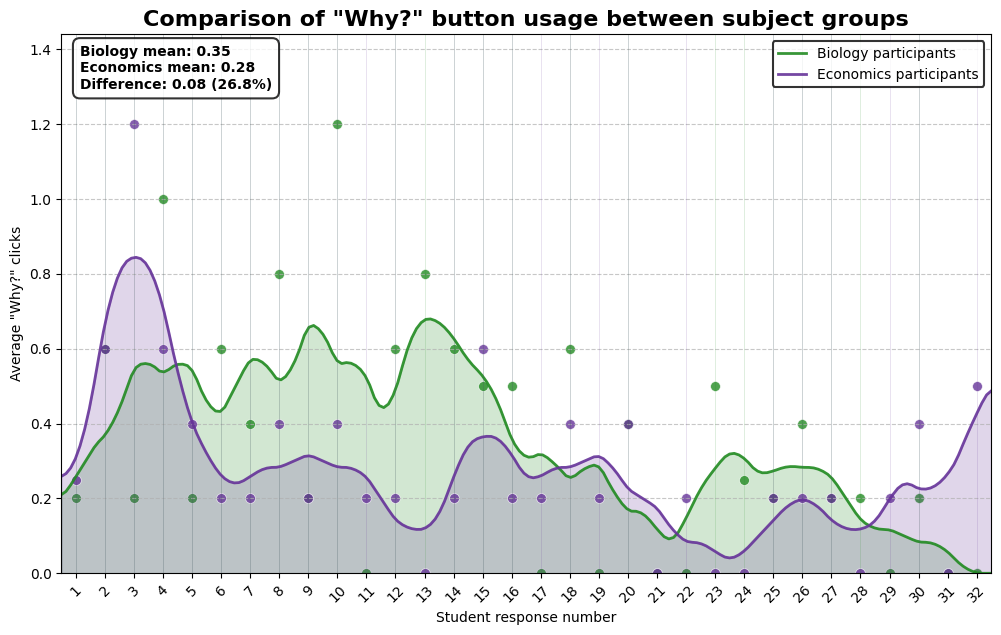

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))

# Process data for biology and economics participants
all_bio_data = _aggregate_action_density(bio_datasets, filtered_actions[0])
all_eco_data = _aggregate_action_density(eco_datasets, filtered_actions[0])

# Set consistent y-axis scaling based on global maximum
global_max = max(all_bio_data['avg_clicks'].max() if not all_bio_data.empty else 0,
                all_eco_data['avg_clicks'].max() if not all_eco_data.empty else 0)
y_max = max(global_max * 1.2, 0.5)

# Generate visualization
_plot_overlay_density(
    [all_bio_data, all_eco_data], 
    ['Biology participants', 'Economics participants'],
    ['forestgreen', 'rebeccapurple'], 
    ax, 
    'Comparison of "Why?" button usage between subject groups',
    max_student=32, 
    fill_alpha=0.2, 
    line_alpha=0.4,
    y_max=y_max
)

# Add summary statistics
bio_mean = all_bio_data['avg_clicks'].mean()
eco_mean = all_eco_data['avg_clicks'].mean()
difference = bio_mean - eco_mean
percent_diff = (difference / eco_mean) * 100 if eco_mean > 0 else 0

summary = f"Biology mean: {bio_mean:.2f}\n"
summary += f"Economics mean: {eco_mean:.2f}\n"
summary += f"Difference: {difference:.2f} ({percent_diff:.1f}%)"

plt.text(0.02, 0.98, summary, 
        ha='left', va='top', transform=ax.transAxes, 
        fontsize=10, fontweight='bold', 
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5',
            edgecolor='black', linewidth=1.5))

#### 'Similar answer' interactions

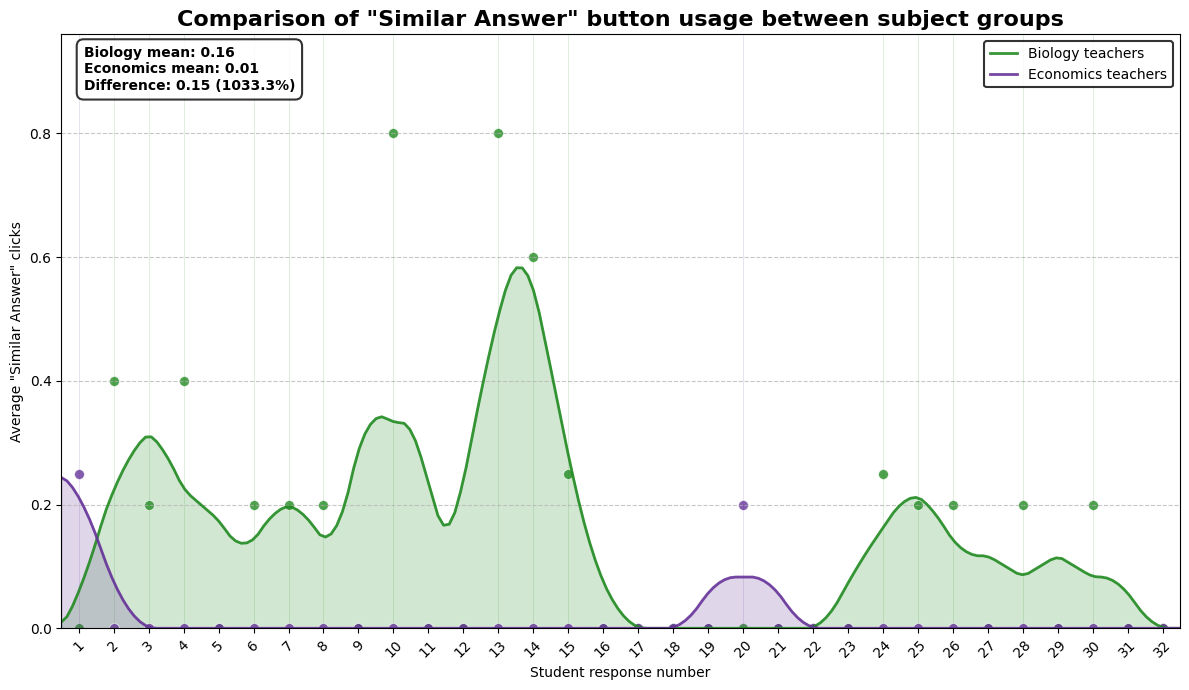

In [ ]:
# Create a single plot for overlaying the similar answer data
fig, ax = plt.subplots(figsize=(12, 7))

# Process all students data for similar answer interactions
all_bio_similar = _aggregate_action_density(bio_datasets, [filtered_actions[2], filtered_actions[4]])
all_eco_similar = _aggregate_action_density(eco_datasets, [filtered_actions[2], filtered_actions[4]])

# Find global maximum for consistent y-axis scaling
global_max = max(all_bio_similar['avg_clicks'].max() if not all_bio_similar.empty else 0,
                all_eco_similar['avg_clicks'].max() if not all_eco_similar.empty else 0)
y_max = max(global_max * 1.2, 0.5)

_plot_overlay_density(
    [all_bio_similar, all_eco_similar], 
    ['Biology teachers', 'Economics teachers'],
    ['forestgreen', 'rebeccapurple'], 
    ax, 
    'Comparison of "Similar Answer" button usage between subject groups',
    max_student=32, 
    fill_alpha=0.2, 
    line_alpha=0.4,
    y_max=y_max
)

# Add summary statistics box
bio_mean = all_bio_similar['avg_clicks'].mean()
eco_mean = all_eco_similar['avg_clicks'].mean()
difference = bio_mean - eco_mean
percent_diff = (difference / eco_mean) * 100 if eco_mean > 0 else 0

summary = f"Biology mean: {bio_mean:.2f}\n"
summary += f"Economics mean: {eco_mean:.2f}\n"
summary += f"Difference: {difference:.2f} ({percent_diff:.1f}%)"

plt.text(0.02, 0.98, summary, 
        ha='left', va='top', transform=ax.transAxes, 
        fontsize=10, fontweight='bold', 
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5',
                  edgecolor='black', linewidth=1.5))  

# Update axis labels to reflect similar answer button
ax.set_ylabel('Average "Similar Answer" clicks')

plt.tight_layout()
plt.show()

## Plot total teachers' interactions 

In [37]:
def _plot_cumulative_density(data, ax, title, max_student, fill_alpha, 
                            line_alpha, bw_adjust, actions, combine_actions, combined_label, y_max=None):
    """
    Plot cumulative density visualization with KDE-like appearance.
    
    Parameters:
    - data: DataFrame with student_nr and avg_clicks
    - ax: Matplotlib axis
    - title: Plot title
    - max_student: Maximum student number to include
    - fill_alpha: Alpha for density fill
    - line_alpha: Alpha for vertical lines
    - bw_adjust: Bandwidth adjustment for KDE smoothing
    - y_max: Optional maximum y-value for consistent scaling
    """
    
    data = data.sort_values('student_nr')
    color = '#505050'  # Dark gray
    
    # Get valid student number range
    min_student = data['student_nr'].min()
    
    # Add vertical reference lines for each data point with non-zero interactions
    for student_nr, avg in zip(data['student_nr'], data['avg_clicks']):
        if avg > 0:
            ax.axvline(x=student_nr, color=color, alpha=line_alpha, 
                      linestyle='-', linewidth=0.5)
    
    # Create a smooth KDE-like curve if enough data points
    if len(data) >= 3:
        try:
            x_smooth = np.linspace(min_student-0.5, max_student+0.5, 100)
            
            # Try cubic spline interpolation for smoother curves
            if len(data) >= 4:  # Need at least 4 points for cubic spline
                from scipy.interpolate import make_interp_spline
                spl = make_interp_spline(data['student_nr'], data['avg_clicks'], k=3)
                y_smooth = spl(x_smooth)
                y_smooth = np.maximum(y_smooth, 0)  # Ensure no negative values
                
                # Add the KDE-like fill
                ax.fill_between(x_smooth, y_smooth, alpha=fill_alpha, color='#C0C0C0')  # Light gray
                ax.plot(x_smooth, y_smooth, color=color, alpha=0.7, linewidth=1)
            else:
                # Fallback to linear interpolation for fewer points
                ax.fill_between(data['student_nr'], data['avg_clicks'], 
                               alpha=fill_alpha, color='#C0C0C0')  # Light gray
        except Exception as e:
            print(f"KDE-like plot failed: {e}")
            ax.fill_between(data['student_nr'], data['avg_clicks'], 
                           alpha=fill_alpha, color='#C0C0C0')  # Light gray
    else:
        # Simple fill for very few points
        ax.fill_between(data['student_nr'], data['avg_clicks'], 
                       alpha=fill_alpha, color='#C0C0C0')  # Light gray
    
    # Draw stem plots for each point
    markerline, stemlines, baseline = ax.stem(
        data['student_nr'], 
        data['avg_clicks'],
        linefmt='-', markerfmt='o', basefmt=' '
    )
    plt.setp(markerline, color=color, markersize=6)
    plt.setp(stemlines, color=color, alpha=0.7, linewidth=1.5)
    
    # Add count labels
    for student_nr, avg in zip(data['student_nr'], data['avg_clicks']):
        if avg > 0:
            ax.text(student_nr, avg + 0.05, f'{avg:.1f}', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Configure axes
    ax.set_xlim(min_student-0.5, max_student+0.5)
    # Use the provided y_max if available, otherwise calculate it from data
    if y_max is not None:
        ax.set_ylim(0, y_max)
    else:
        ax.set_ylim(0, max(data['avg_clicks'].max() * 1.2, 0.5))
    
    # Set x-ticks to show student numbers clearly
    unique_students = sorted(data['student_nr'].unique())
    ax.set_xticks(unique_students)
    ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
    
    # Set title based on actions
    action_label = "'Why'"
    if isinstance(actions, list) and len(actions) == 1:
        action_label = f"'{actions[0]}'"
    elif combine_actions and combined_label:
        action_label = f"'{combined_label}'"
    
    ax.set_title(title)
    ax.set_xlabel('Student response number')
    ax.set_ylabel(f'Average {action_label} clicks')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    summary = f"Average: {data['avg_clicks'].mean():.2f}"

    ax.text(0.95, 0.95, summary, 
            ha='right', va='top', transform=ax.transAxes, 
            fontsize=10, fontweight='bold', 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', 
                    edgecolor='#505050', linewidth=1.5))  

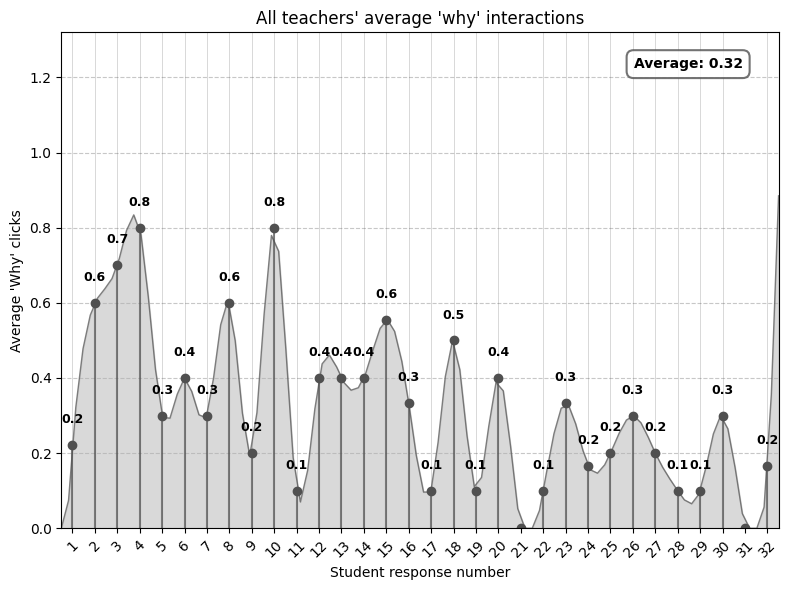

In [39]:
# Plot the combined average 'why' interactions across all participants
fig_combined, ax_combined = plt.subplots(figsize=(8, 6))

# Create combined dataset from both subject groups
combined_datasets = {**bio_datasets, **eco_datasets}
all_combined_data = _aggregate_action_density(combined_datasets, filtered_actions[0])

# Set consistent y-axis scaling based on the maximum values from individual subject plots
global_max = max(all_bio_data['avg_clicks'].max() if not all_bio_data.empty else 0,
                 all_eco_data['avg_clicks'].max() if not all_eco_data.empty else 0)
y_max = max(global_max * 1.1, 0.1)  

# Generate the visualization with gray color scheme
_plot_cumulative_density(all_combined_data, ax_combined, 
                        f"All teachers' average 'why' interactions", 
                        max_student=32, fill_alpha=0.6, line_alpha=0.3, bw_adjust=1.5,
                        actions=filtered_actions[0], combine_actions=False, 
                        combined_label="'Why' clicks", y_max=y_max)

plt.tight_layout()
plt.show()

## Interaction count comparison type A vs. type B responses

### At the response level

#### Functions

In [41]:
def extract_click_level_data(datasets, action_type='Waarom?'):
    """
    Extract individual clicks as separate observations.
    
    Parameters:
    - datasets: Dictionary of {teacher_name: dataframe} pairs
    - action_type: Type of action to analyze ('Waarom?' or other action types)
    
    Returns:
    - DataFrame with each click as an observation
    """
    all_clicks = []
    
    for teacher_name, df in datasets.items():
        # Pre-process data
        processed_df = pre_process_df(df)

        # Filter for the specified action type
        action_clicks = processed_df[processed_df[action_type] == True]
        
        # Skip if no clicks of this type
        if len(action_clicks) == 0:
            continue
            
        # For each click, create an observation
        for _, click in action_clicks.iterrows():
            # Determine if this is a gray area response (even student IDs)
            is_gray_area = click['studentId'] % 2 == 0
            
            # Create an observation for this click
            click_data = {
                'teacher': teacher_name,
                'subject': 'Biology' if 'Biology' in teacher_name else 'Economics',
                'student_nr': click['student_nr'],
                'student_id': click['studentId'],
                'question_id': click['question_id'],
                'timestamp': click['timestamp'],
                'action': action_type,
                'is_gray_area': is_gray_area,
                'complexity': 'Gray Area' if is_gray_area else 'Non-Gray Area'
            }
            
            all_clicks.append(click_data)
    
    # Create DataFrame from all clicks
    clicks_df = pd.DataFrame(all_clicks)
    
    return clicks_df

In [42]:
def combine_subject_clicks(bio_datasets, eco_datasets, action_type='Waarom?'):
    """Combine click data from both subjects"""
    bio_clicks = extract_click_level_data(bio_datasets, action_type)
    eco_clicks = extract_click_level_data(eco_datasets, action_type)
    
    # Combine datasets
    all_clicks = pd.concat([bio_clicks, eco_clicks], ignore_index=True)
    
    return all_clicks

In [45]:
# First, let's create a complete dataset with all 160 possible response points
# (5 teachers × 32 responses per teacher)

# Create a function to check if a student response received a click
def create_complete_dataset(clicks_df):
    teachers = clicks_df['teacher'].unique()
    
    all_responses = []
    
    for teacher in teachers:
        # Each teacher should have 32 responses (student_nr from 1 to 32)
        for student_nr in range(1, 33):
            # Determine if this is a gray area response (even student_id)
            is_gray_area = student_nr % 2 == 0
            
            # Check if this student_nr received a click for this teacher
            clicked = clicks_df[(clicks_df['teacher'] == teacher) & 
                              (clicks_df['student_nr'] == student_nr)].shape[0] > 0
            
            # Add to dataset
            all_responses.append({
                'teacher': teacher,
                'student_nr': student_nr,
                'is_gray_area': is_gray_area,
                'Complexity': 'Gray area' if is_gray_area else 'Non-gray area',
                'clicked': 1 if clicked else 0 
            })
    
    return pd.DataFrame(all_responses)

#### Calculations

In [44]:
bio_clicks = extract_click_level_data(bio_datasets, 'Waarom?')
eco_clicks = extract_click_level_data(eco_datasets, 'Waarom?')
all_why_clicks = combine_subject_clicks(bio_datasets, eco_datasets, 'Waarom?')

display(all_why_clicks.head())

,teacher,subject,student_nr,student_id,question_id,timestamp,action,is_gray_area,complexity
0,Biology 1,Biology,2,2,1,2025-04-29 10:00:28.544000+00:00,Waarom?,True,Gray Area
1,Biology 1,Biology,4,4,1,2025-04-29 10:04:24.936000+00:00,Waarom?,True,Gray Area
2,Biology 1,Biology,6,6,1,2025-04-29 10:06:20.932000+00:00,Waarom?,True,Gray Area
3,Biology 1,Biology,8,8,1,2025-04-29 10:07:45.097000+00:00,Waarom?,True,Gray Area
4,Biology 1,Biology,10,2,2,2025-04-29 10:12:20.162000+00:00,Waarom?,True,Gray Area


In [54]:
# Create the complete dataset
complete_dataset = create_complete_dataset(all_why_clicks)
display(complete_dataset.head())

# Create a mapping dictionary for type response labels
label_map = {'Gray area': 'Type A', 'Non-gray area': 'Type B'}

# Update the Complexity column with the new labels
complete_dataset['Complexity'] = complete_dataset['Complexity'].map(label_map)

# Summarize clicks by teacher and response type
summary = complete_dataset.groupby(['teacher', 'Complexity'])['clicked'].agg(['sum', 'count']).reset_index()
summary['click_rate'] = summary['sum'] / summary['count']

print("Summary of clicks by teacher and response type:")
display(summary.head())


,teacher,student_nr,is_gray_area,Complexity,clicked
0,Biology 1,1,False,Non-gray area,0
1,Biology 1,2,True,Gray area,1
2,Biology 1,3,False,Non-gray area,0
3,Biology 1,4,True,Gray area,1
4,Biology 1,5,False,Non-gray area,0


Summary of clicks by teacher and response type:


,teacher,Complexity,sum,count,click_rate
0,Biology 1,Type A,9,16,0.5625
1,Biology 1,Type B,3,16,0.1875
2,Biology 2,Type A,11,16,0.6875
3,Biology 2,Type B,7,16,0.4375
4,Biology 3,Type A,1,16,0.0625


#### Plot type A vs. type B interaction per participant

C:\Users\lotteg\AppData\Local\Temp\ipykernel_27492\3802873986.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45)


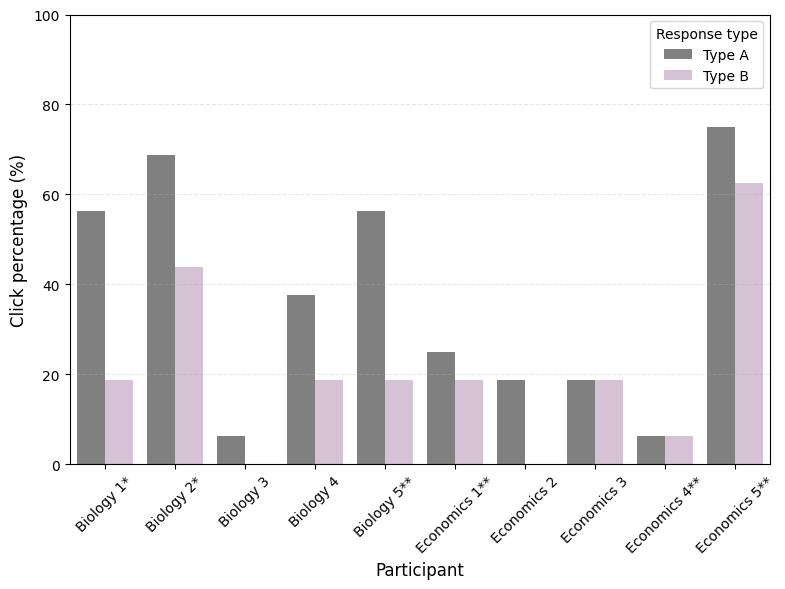

In [55]:
# Create a figure with appropriate dimensions
plt.figure(figsize=(8, 6))

# Create a copy of the summary dataframe and convert click rate to percentage
summary_pct = summary.copy()
summary_pct['click_rate_percentage'] = summary_pct['click_rate'] * 100

# Define your color palette with the new labels
color_palette = {'Type A': 'gray', 'Type B': 'thistle'}

# Create the barplot with the new labels
sns.barplot(x='teacher', y='click_rate_percentage', hue='Complexity', 
           data=summary_pct, hue_order=['Type A', 'Type B'],
           palette=color_palette)

# Set labels and formatting
plt.ylabel('Click percentage (%)', fontsize=12)
plt.xlabel('Participant', fontsize=12)

# Get current tick labels
xlabels = plt.gca().get_xticklabels()
new_labels = []

# Add asterisks to specific teachers
for label in xlabels:
    text = label.get_text()
    if text == 'Biology 1' or text == 'Biology 2':
        new_labels.append(text + '*')
    elif text == 'Biology 5' or text == 'Economics 1' or text == 'Economics 4' or text == 'Economics 5':
        new_labels.append(text + '**')
    else:
        new_labels.append(text)

# Apply the new labels
plt.gca().set_xticklabels(new_labels, rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to 0-100%

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add a legend with better positioning
plt.legend(title='Response type', loc='upper right')

plt.tight_layout()

plt.show()

## Bayesian analysis for task complexity interaction

In [78]:
# Create model with formula notation
model = bmb.Model("clicked ~ is_gray_area + (1|teacher)", 
                  complete_dataset, family="bernoulli")

# Sample from posterior
results = model.fit(draws=1000, tune=500, target_accept=0.8)

# Get summary
summary = az.summary(results) 
print(summary)

# Get odds ratio and CI
beta_samples = results.posterior['is_gray_area'].values.flatten()
odds_ratio = np.exp(beta_samples)
or_mean = odds_ratio.mean()
or_ci = np.percentile(odds_ratio, [2.5, 97.5])
print(f"Odds Ratio: {or_mean:.3f}, 95% CI: [{or_ci[0]:.3f}, {or_ci[1]:.3f}]")

Modeling the probability that clicked==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, is_gray_area, 1|teacher_sigma, 1|teacher_offset]


c:\Users\lotteg\OneDrive - Stichting Cito Instituut voor Toetsontwikkeling\Documenten\Python 
Scripts\.venv\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2115 seconds.


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              -1.600  0.506  -2.551   -0.636      0.019    0.022   
is_gray_area            0.991  0.285   0.445    1.512      0.005    0.005   
1|teacher_sigma         1.417  0.472   0.708    2.280      0.023    0.038   
1|teacher[Biology 1]    0.500  0.589  -0.610    1.579      0.019    0.018   
1|teacher[Biology 2]    1.269  0.578   0.244    2.402      0.018    0.017   
1|teacher[Biology 3]   -1.870  0.829  -3.350   -0.294      0.022    0.015   
1|teacher[Biology 4]    0.072  0.600  -1.028    1.203      0.020    0.024   
1|teacher[Biology 5]    0.503  0.586  -0.583    1.582      0.018    0.019   
1|teacher[Economics 1] -0.255  0.615  -1.393    0.932      0.020    0.019   
1|teacher[Economics 2] -1.131  0.696  -2.455    0.192      0.020    0.020   
1|teacher[Economics 3] -0.443  0.623  -1.547    0.779      0.019    0.019   
1|teacher[Economics 4] -1.453  0.740  -2.829   -0.122      0.021    0.019   

### Check results

In [ ]:
def check_mcmc_diagnostics(results, rhat_threshold=1.05, ess_threshold=100):
    """Check MCMC diagnostics for a bambi/pymc model fit."""
    # Get summary statistics
    summary = az.summary(results)
    
    # Check Rhat values
    bad_rhat = summary[summary['r_hat'] > rhat_threshold]
    
    # Check ESS values
    low_ess = summary[(summary['ess_bulk'] < ess_threshold) | (summary['ess_tail'] < ess_threshold)]
    
    # Check divergences
    divergences = results.sample_stats.diverging.sum().values
    divergence_rate = divergences / len(results.sample_stats.diverging.values.flatten()) * 100
    
    # Print results
    print("=== MCMC Diagnostics ===")
    print(f"Total parameters: {len(summary)}")
    
    if len(bad_rhat) > 0:
        print(f"\nParameters with Rhat > {rhat_threshold} (possible non-convergence):")
        display(bad_rhat)
    else:
        print(f"\nAll parameters have Rhat < {rhat_threshold}")
    
    if len(low_ess) > 0:
        print(f"\nParameters with ESS < {ess_threshold} (possible inefficient sampling):")
        display(low_ess)
    else:
        print(f"\nAll parameters have ESS > {ess_threshold}")
    
    print(f"\nDivergences: {divergences} ({divergence_rate:.2f}%)")
    if divergence_rate > 1:
        print("Warning: High divergence rate may indicate model misspecification")
    else:
        print("Divergence rate is acceptable")
    
    # Plot traces
    print("\nTrace plots (should look like 'hairy caterpillars'):")
    az.plot_trace(results)
    plt.tight_layout()
    
    return {'bad_rhat': bad_rhat, 'low_ess': low_ess, 'divergence_rate': divergence_rate}

=== MCMC Diagnostics ===
Total parameters: 13

All parameters have Rhat < 1.05 ✓

All parameters have ESS > 100 ✓

Divergences: 0 (0.00%)
Divergence rate is acceptable ✓

Trace plots (should look like 'hairy caterpillars'):


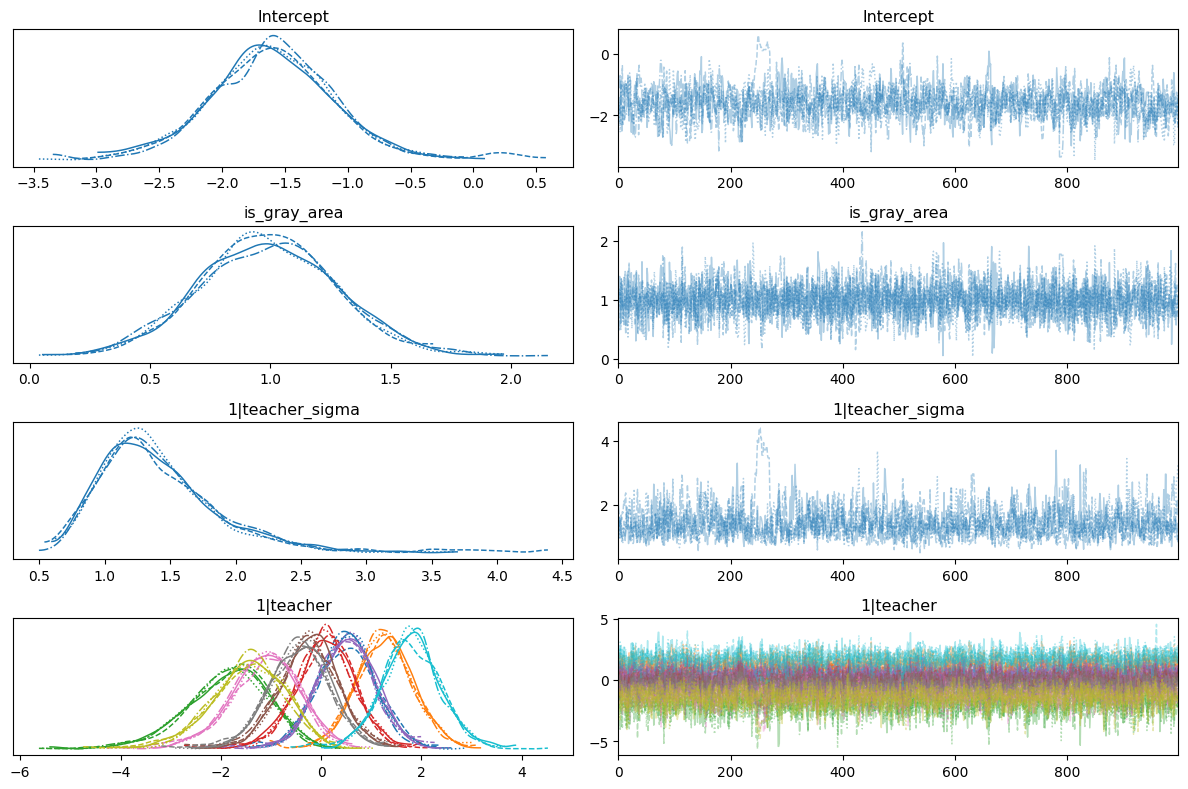

In [80]:
diagnostics = check_mcmc_diagnostics(results)

### Plot bayesian results

Type A CI:  [0.17444688 0.5966488 ]
Type B CI:  [0.06851283 0.36186844]


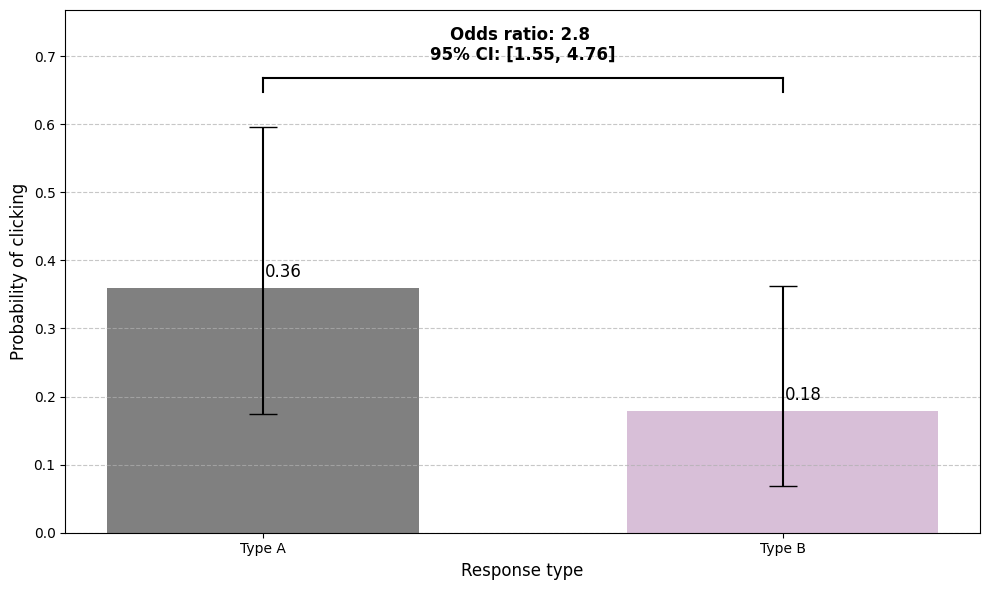

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Extract posterior samples from the model results
intercept_samples = results.posterior['Intercept'].values.flatten()
effect_samples = results.posterior['is_gray_area'].values.flatten()

# Convert log-odds to probabilities
non_gray_probs = 1 / (1 + np.exp(-intercept_samples))
gray_probs = 1 / (1 + np.exp(-(intercept_samples + effect_samples)))

# Calculate mean probabilities
non_gray_mean = non_gray_probs.mean()
gray_mean = gray_probs.mean()

non_gray_ci = np.percentile(non_gray_probs, [2.5, 97.5])
gray_ci = np.percentile(gray_probs, [2.5, 97.5])

print("Type A CI: ", gray_ci)
print("Type B CI: ", non_gray_ci)
non_gray_err = [non_gray_mean - non_gray_ci[0], non_gray_ci[1] - non_gray_mean]
gray_err = [gray_mean - gray_ci[0], gray_ci[1] - gray_mean]

categories = ["Type A", "Type B"]  
values = [gray_mean, non_gray_mean]  
err = np.array([
    [gray_err[0], non_gray_err[0]],  
    [gray_err[1], non_gray_err[1]] 
])

# Reversed color order to match the data
bars = ax.bar(categories, values, yerr=err, capsize=10, 
           color=['gray', 'thistle'], width=0.6)

# Odds ratio annotation with bold text
y_height = max(values) + max(gray_ci[1] - gray_mean, non_gray_ci[1] - non_gray_mean) * 1.3
odds_text = f"Odds ratio: 2.8 \n95% CI: [{or_ci[0]:.2f}, {or_ci[1]:.2f}]"

# Draw the connection bar (also reversed)
ax.plot([0, 1], [y_height, y_height], 'k', linewidth=1.5)
ax.plot([0, 0], [y_height-0.02, y_height], 'k', linewidth=1.5)
ax.plot([1, 1], [y_height-0.02, y_height], 'k', linewidth=1.5)
ax.text(0.5, y_height+0.02, odds_text, ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + 0.04 + bar.get_width()/2., height + 0.01,
           f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Set labels and title
ax.set_ylabel('Probability of clicking', fontsize=12)
ax.set_ylim(0, min(1.0, y_height+0.1))  
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Response type', fontsize=12)

plt.tight_layout()
plt.show()

## Interaction per participant group

In [73]:
def plot_cumulative_action_density(
    datasets, 
    actions=['Waarom?'],
    title="Cumulative Interaction Density",
    max_student=32,
    figsize=(18, 6),
    fill_alpha=0.6,
    line_alpha=0.3,
    bw_adjust=0.7,
    combine_actions=False,
    combined_label=None
):
    """
    Create plots showing the average action density across multiple datasets.
    
    Parameters:
    - datasets: Dictionary of {name: dataframe} pairs
    - actions: List of action types to include
    - title_prefix: Prefix for the plot title
    - max_student: Maximum student number to include
    - figsize: Figure size as tuple (width, height)
    - fill_alpha: Alpha for density fill
    - line_alpha: Alpha for vertical lines
    - bw_adjust: Bandwidth adjustment for KDE smoothing
    - combine_actions: Whether to combine multiple actions
    - combined_label: Custom label for combined actions
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    
    # Process all students data
    all_data = _aggregate_action_density(datasets, actions, None, 
                                        combine_actions, max_student)
    
    # Process non-gray area students (odd IDs)
    odd_data = _aggregate_action_density(datasets, actions, 
                                       lambda df: df[df['studentId'] % 2 == 1],
                                       combine_actions, max_student)
    
    # Process gray area students (even IDs)
    even_data = _aggregate_action_density(datasets, actions, 
                                        lambda df: df[df['studentId'] % 2 == 0],
                                        combine_actions, max_student)
    
    # Find the global maximum value across all datasets
    global_max = max(
        all_data['avg_clicks'].max() if not all_data.empty else 0,
        odd_data['avg_clicks'].max() if not odd_data.empty else 0,
        even_data['avg_clicks'].max() if not even_data.empty else 0
    )
    
    # Add some padding (20%) and ensure minimum height of 0.5
    y_max = max(global_max * 1.2, 0.5)
    
    # Plot with consistent y-axis
    _plot_cumulative_density(all_data, ax1, f"All students", 
                            max_student, fill_alpha, line_alpha, bw_adjust,
                            actions, combine_actions, combined_label, y_max)
    
    _plot_cumulative_density(odd_data, ax2, f"Non-gray area students", 
                            max_student, fill_alpha, line_alpha, bw_adjust,
                            actions, combine_actions, combined_label, y_max)
    
    _plot_cumulative_density(even_data, ax3, f"Gray area students", 
                            max_student, fill_alpha, line_alpha, bw_adjust,
                            actions, combine_actions, combined_label, y_max)
    
    plt.tight_layout()
    plt.show()
    return fig, (all_data, odd_data, even_data)


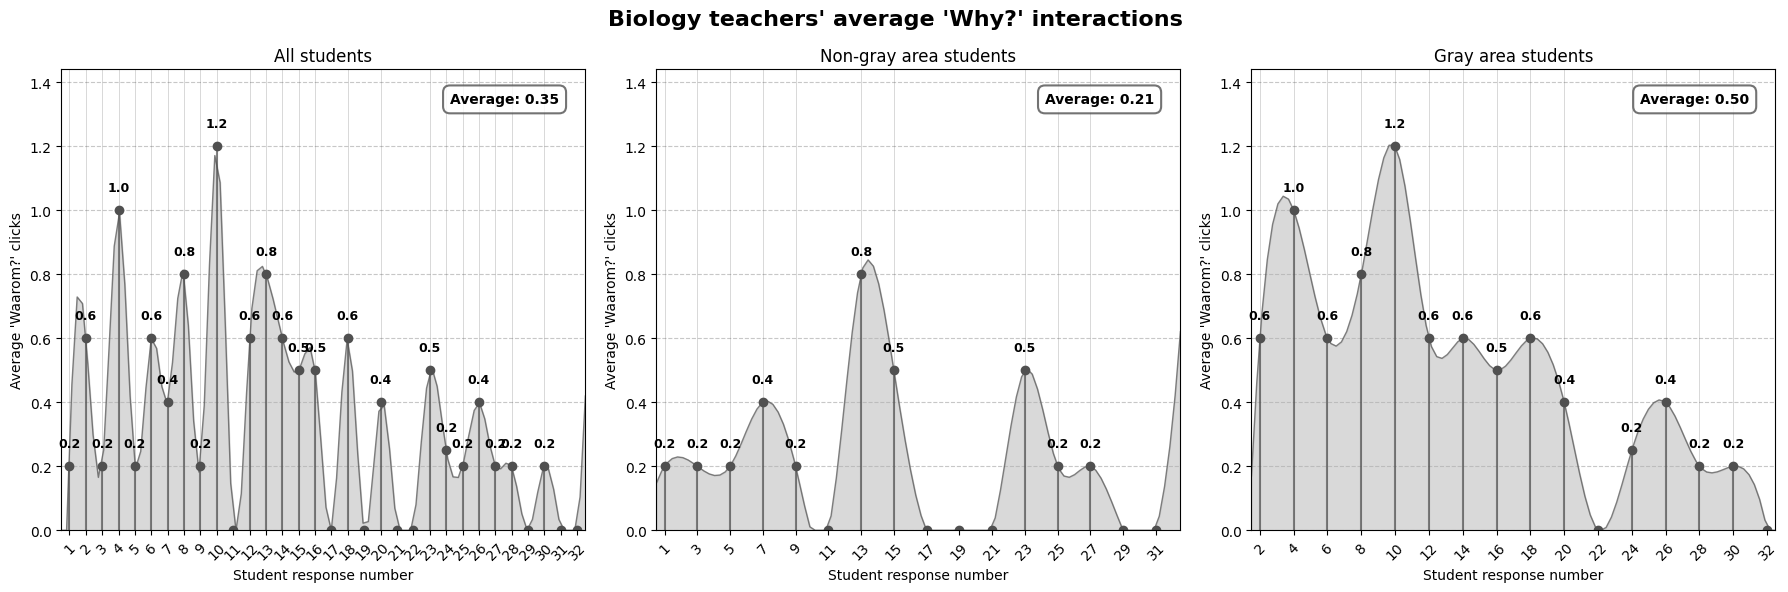

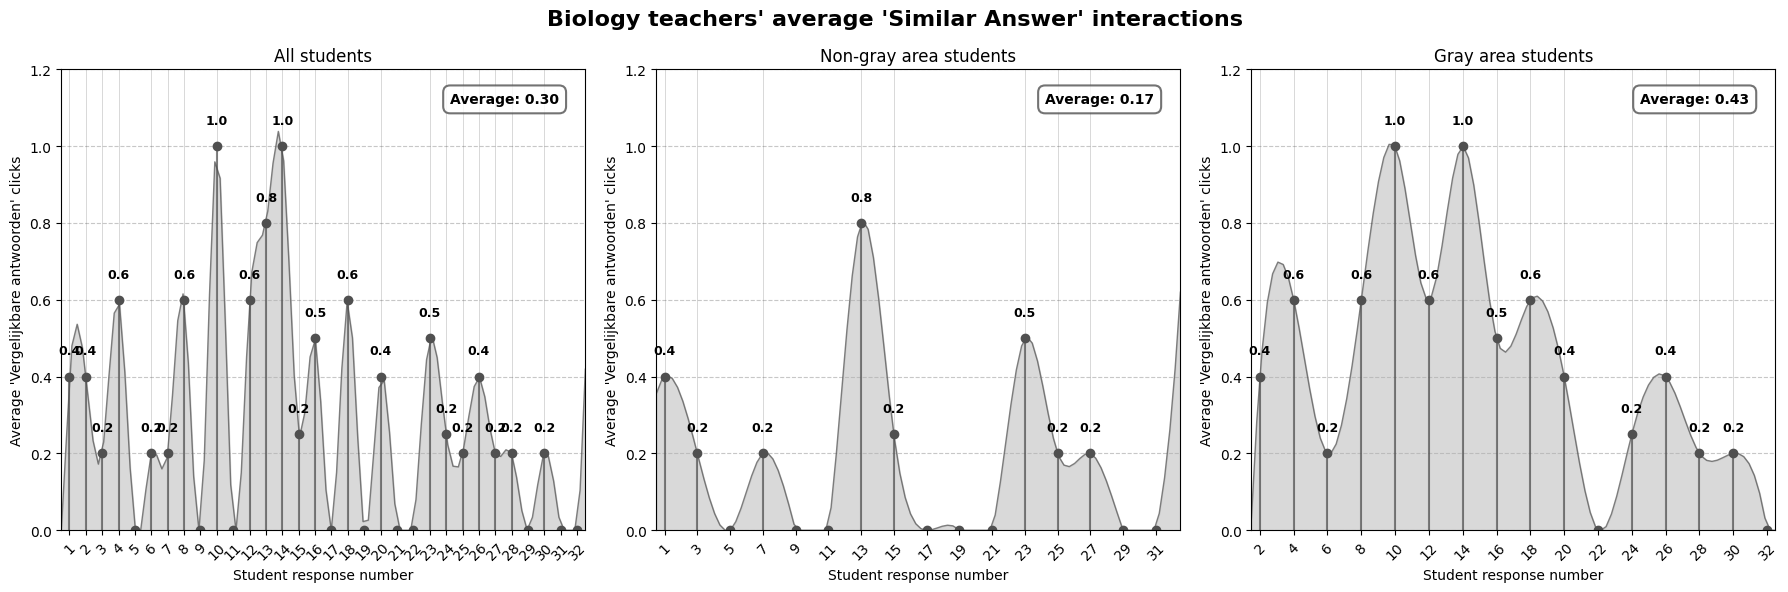

In [74]:
# For all biology datasets with "Waarom?" action
fig, bio_results_why = plot_cumulative_action_density(
    bio_datasets, 
    actions=[filtered_actions[0]],
    title ="Biology teachers' average 'Why?' interactions",
    max_student=32
)

# For all biology datasets with "Vergelijkbare antwoorden" actions
fig, bio_results_va = plot_cumulative_action_density(
    bio_datasets,
    actions=[filtered_actions[2], filtered_actions[4]],
    title="Biology teachers' average 'Similar Answer' interactions",
    combine_actions=True,
    combined_label="Vergelijkbare antwoorden"
)

In [75]:
(bio_why_all, bio_why_nongray, bio_why_gray) = bio_results_why
(bio_va_all, bio_va_nongray, bio_va_gray) = bio_results_va

# Example of data
display(bio_why_all.head())

,student_nr,avg_clicks,click_percentage,max_clicks,total_datasets
0,1,0.2,20,1,5
1,2,0.6,60,1,5
2,3,0.2,20,1,5
3,4,1.0,100,2,5
4,5,0.2,20,1,5


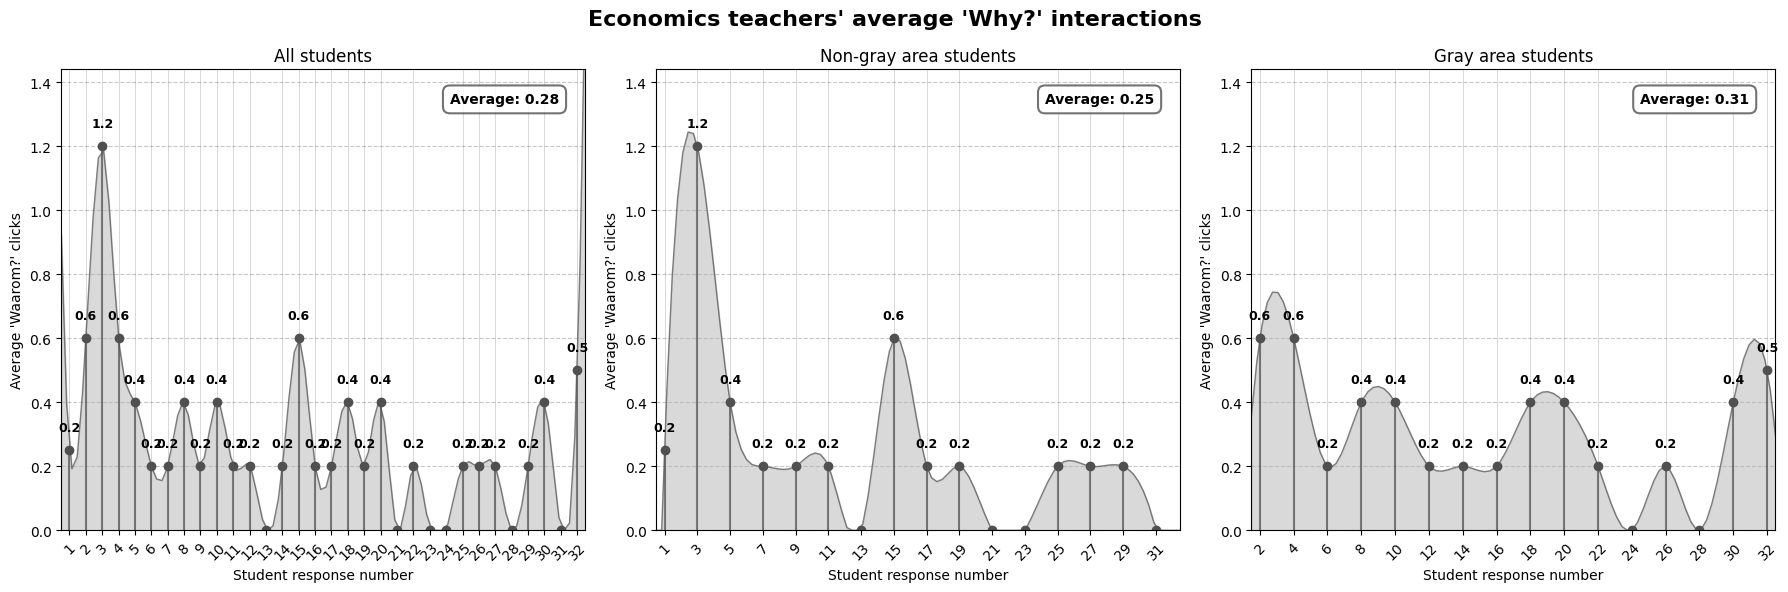

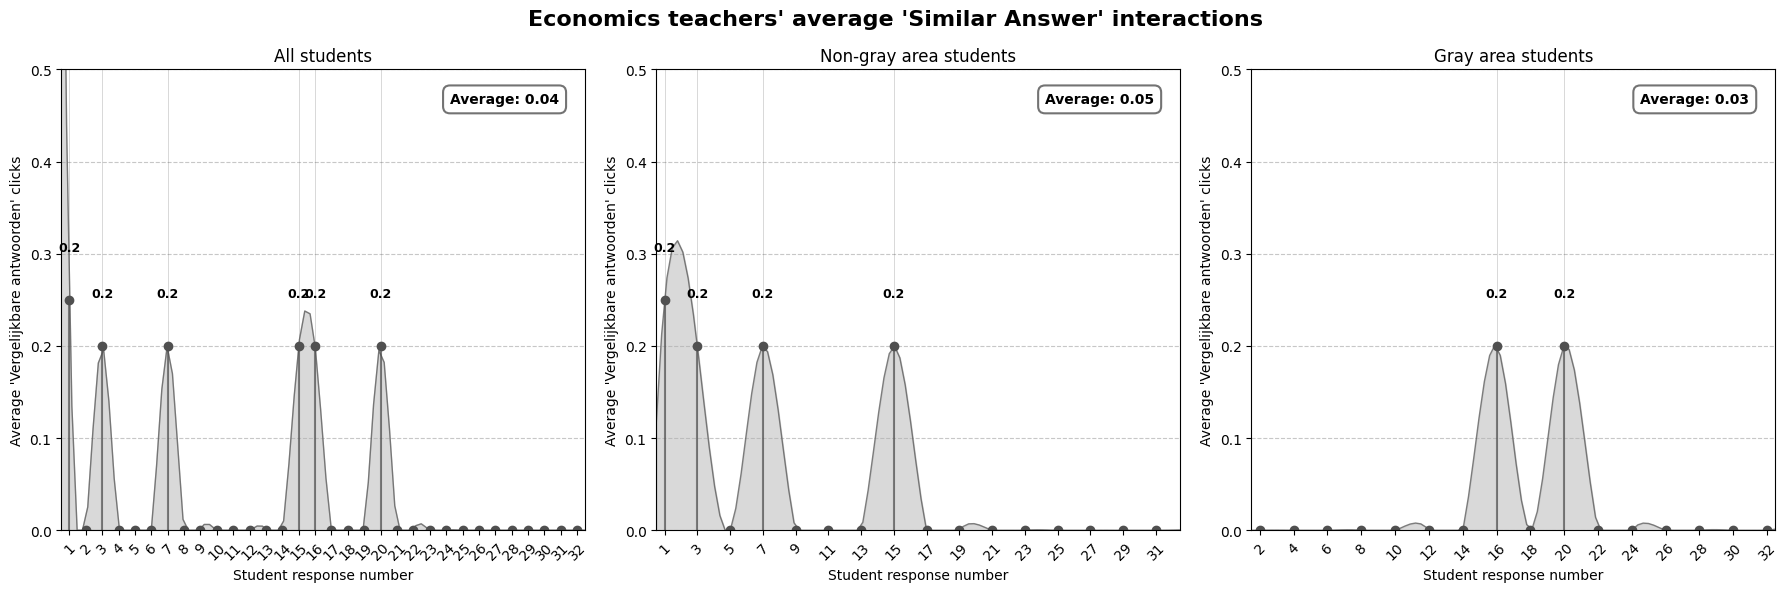

In [76]:
# For all economics datasets with "Waarom?" action
fig, eco_results_why = plot_cumulative_action_density(
    eco_datasets, 
    actions=[filtered_actions[0]],
    title ="Economics teachers' average 'Why?' interactions",
    max_student=32
)

# For all economics datasets with "Vergelijkbare antwoorden" actions
fig, eco_results_va = plot_cumulative_action_density(
    eco_datasets,
    actions=[filtered_actions[2], filtered_actions[4]],
    title="Economics teachers' average 'Similar Answer' interactions",
    combine_actions=True,
    combined_label="Vergelijkbare antwoorden"
)

In [77]:
(eco_why_all, eco_why_nongray, eco_why_gray) = eco_results_why
(eco_va_all, eco_va_nongray, eco_va_gray) = eco_results_va

#### Combined data

In [78]:
# Combine biology + economics interactions
total_why_nongray = pd.concat([bio_why_nongray, eco_why_nongray], ignore_index=True)
total_why_gray = pd.concat([bio_why_gray, eco_why_gray], ignore_index=True)

# If you also want to analyze the "vergelijkbare antwoorden" clicks
total_va_nongray = pd.concat([bio_va_nongray, eco_va_nongray], ignore_index=True)
total_va_gray = pd.concat([bio_va_gray, eco_va_gray], ignore_index=True)

In [ ]:
display(total_why_nongray.head())

,student_nr,avg_clicks,click_percentage,max_clicks,total_datasets
0,1,0.2,20,1,5
1,3,0.2,20,1,5
2,5,0.2,20,1,5
3,7,0.4,40,1,5
4,9,0.2,20,1,5


#### Combined participant group plots

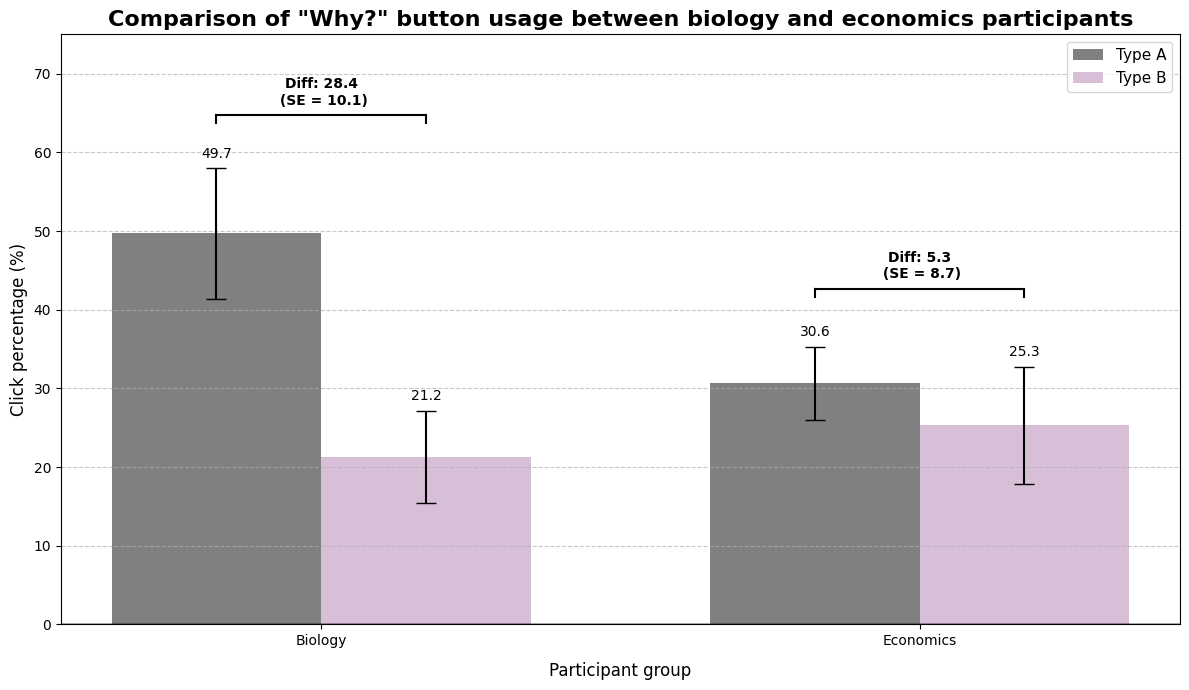

In [80]:

fig, ax = plt.subplots(figsize=(12, 7))

# Create data structure for the plot
subjects = ['Biology', 'Economics']
response_types = ['Type A', 'Type B']  

data = {
    'Biology': {
        'Type B': bio_why_nongray['click_percentage'].mean(), 
        'Type A': bio_why_gray['click_percentage'].mean()      
    },
    'Economics': {
        'Type B': eco_why_nongray['click_percentage'].mean(),  
        'Type A': eco_why_gray['click_percentage'].mean()      
    }
}

# Calculate standard errors for error bars
errors = {
    'Biology': {
        'Type B': bio_why_nongray['click_percentage'].std() / np.sqrt(len(bio_why_nongray)),
        'Type A': bio_why_gray['click_percentage'].std() / np.sqrt(len(bio_why_gray))
    },
    'Economics': {
        'Type B': eco_why_nongray['click_percentage'].std() / np.sqrt(len(eco_why_nongray)),
        'Type A': eco_why_gray['click_percentage'].std() / np.sqrt(len(eco_why_gray))
    }
}

x = np.arange(len(subjects))
bar_width = 0.35

# Define colors for response types
colors = {'Type A': 'gray', 'Type B': 'thistle'}  


bars = []
ax.set_ylim(0, 75) 

# Create the bars
for i, response_type in enumerate(response_types):
    response_values = [data[subject][response_type] for subject in subjects]
    error_values = [errors[subject][response_type] for subject in subjects]
    
    position = x + (i - 0.5) * bar_width
    bar = ax.bar(position, response_values, width=bar_width, 
                color=colors[response_type], 
                yerr=error_values, capsize=7, ecolor='black',
                label=response_type)
    
    # Add value labels on top of each bar
    for j, value in enumerate(response_values):
        ax.text(position[j], value + error_values[j] + 1, 
                f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    bars.append(bar)

# Add lines and text to show differences between Type B and Type A for each subject
for i, subject in enumerate(subjects):
    type_b_val = data[subject]['Type B']
    type_a_val = data[subject]['Type A']
    diff = type_a_val - type_b_val
    
    # Calculate SE of the difference
    type_b_se = errors[subject]['Type B']
    type_a_se = errors[subject]['Type A']
    diff_se = np.sqrt(type_a_se**2 + type_b_se**2)
    
    y_offset = 5 if subject == 'Biology' else 2
    
    # Draw a line connecting the bars
    x1 = x[i] - bar_width/2
    x2 = x[i] + bar_width/2
    y = max(type_a_val, type_b_val) + y_offset + 10
    
    ax.plot([x1, x2], [y, y], 'k-', linewidth=1.5)
    ax.plot([x1, x1], [y-1, y], 'k-', linewidth=1.5)
    ax.plot([x2, x2], [y-1, y], 'k-', linewidth=1.5)
    
    # Add the difference text with standard error
    ax.text((x1+x2)/2, y+1, f'Diff: {diff:.1f}\n (SE = {diff_se:.1f})', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('Comparison of "Why?" button usage between biology and economics participants', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(subjects)

ax.set_ylabel('Click percentage (%)', fontsize=12)
ax.set_xlabel('Participant group', fontsize=12, labelpad=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


In [81]:
# Print the standard error values for each bar
print("\nStandard Errors:")
print(f"Biology Type A: {errors['Biology']['Type A']:.2f}")
print(f"Biology Type B: {errors['Biology']['Type B']:.2f}")
print(f"Economics Type A: {errors['Economics']['Type A']:.2f}")
print(f"Economics Type B: {errors['Economics']['Type B']:.2f}")


Standard Errors:
Biology Type A: 8.27
Biology Type B: 5.84
Economics Type A: 4.61
Economics Type B: 7.41


## Bio interactions with "waarom" button

The probability density plots show when and how often participants used the "why" button

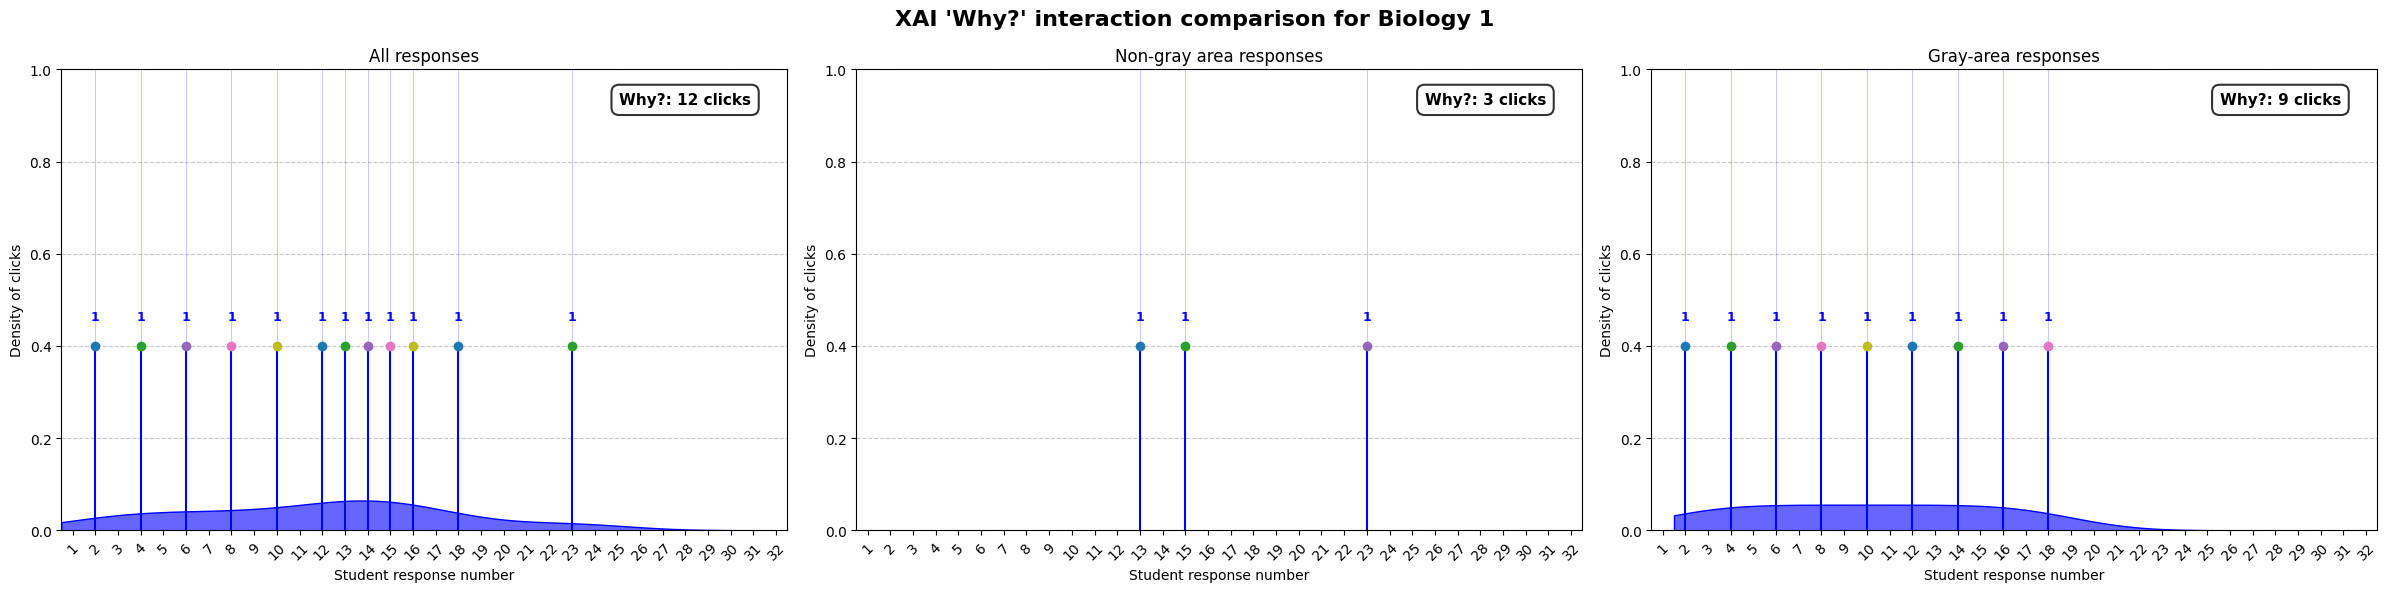

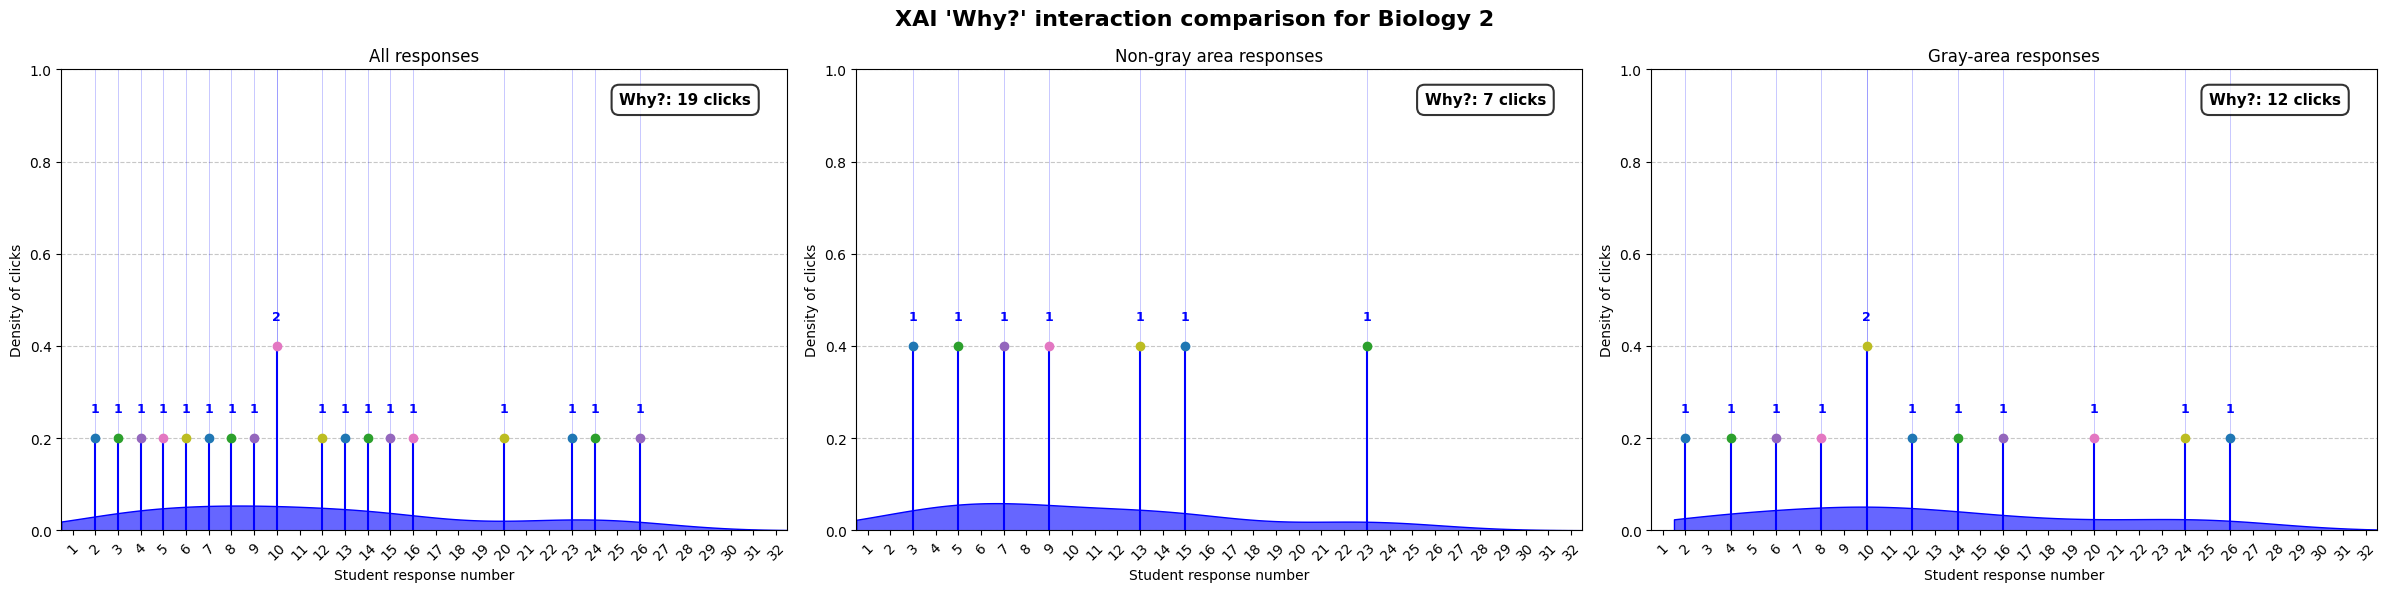

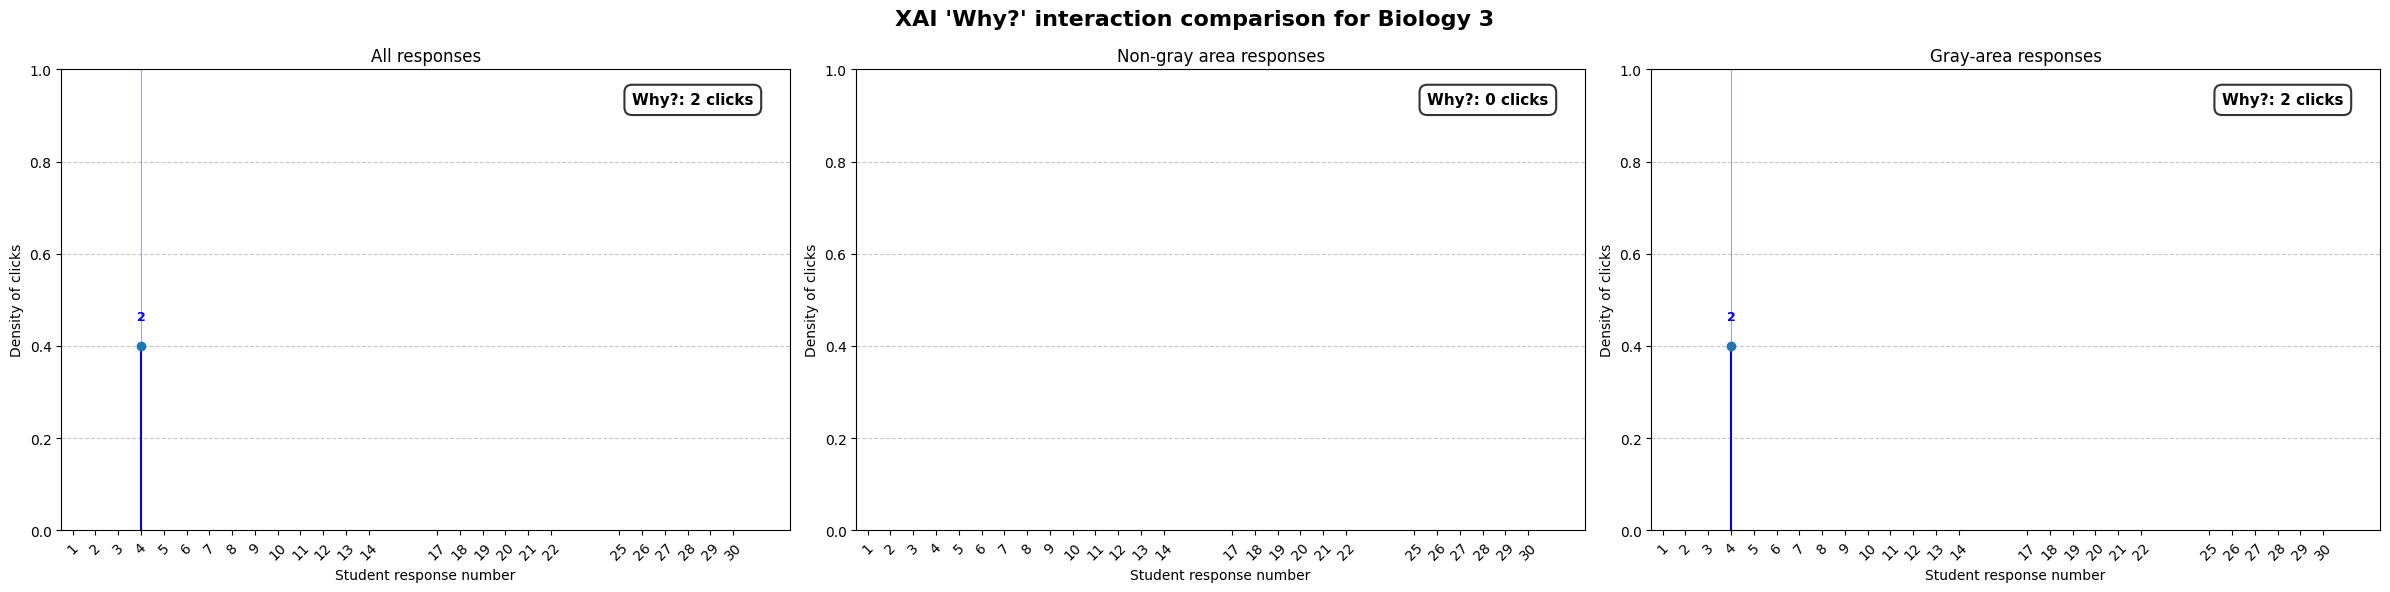

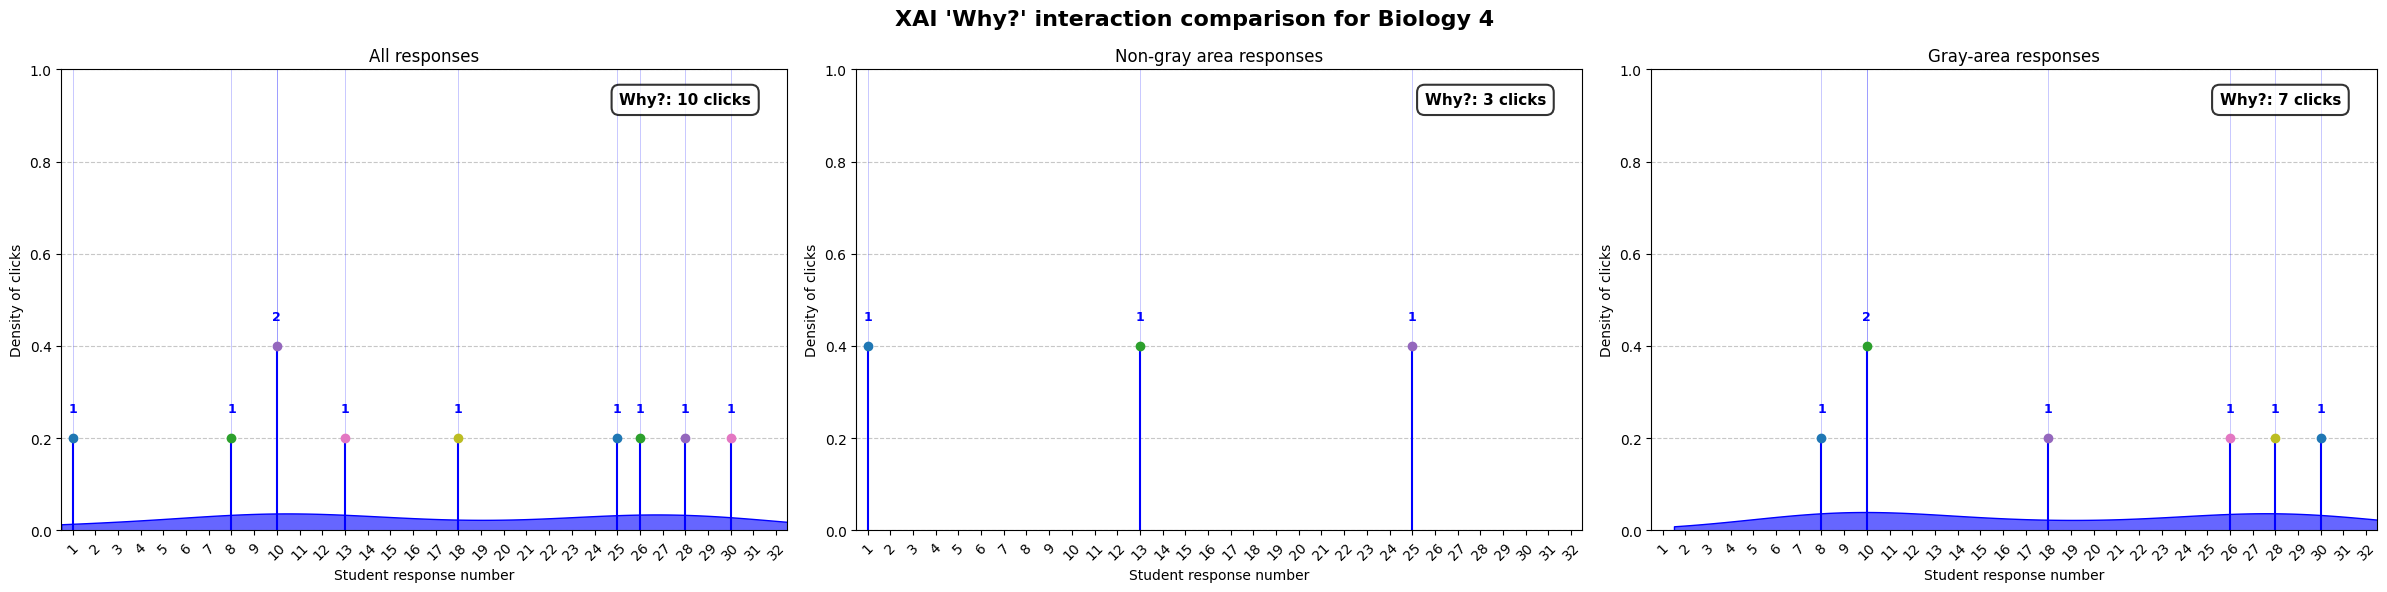

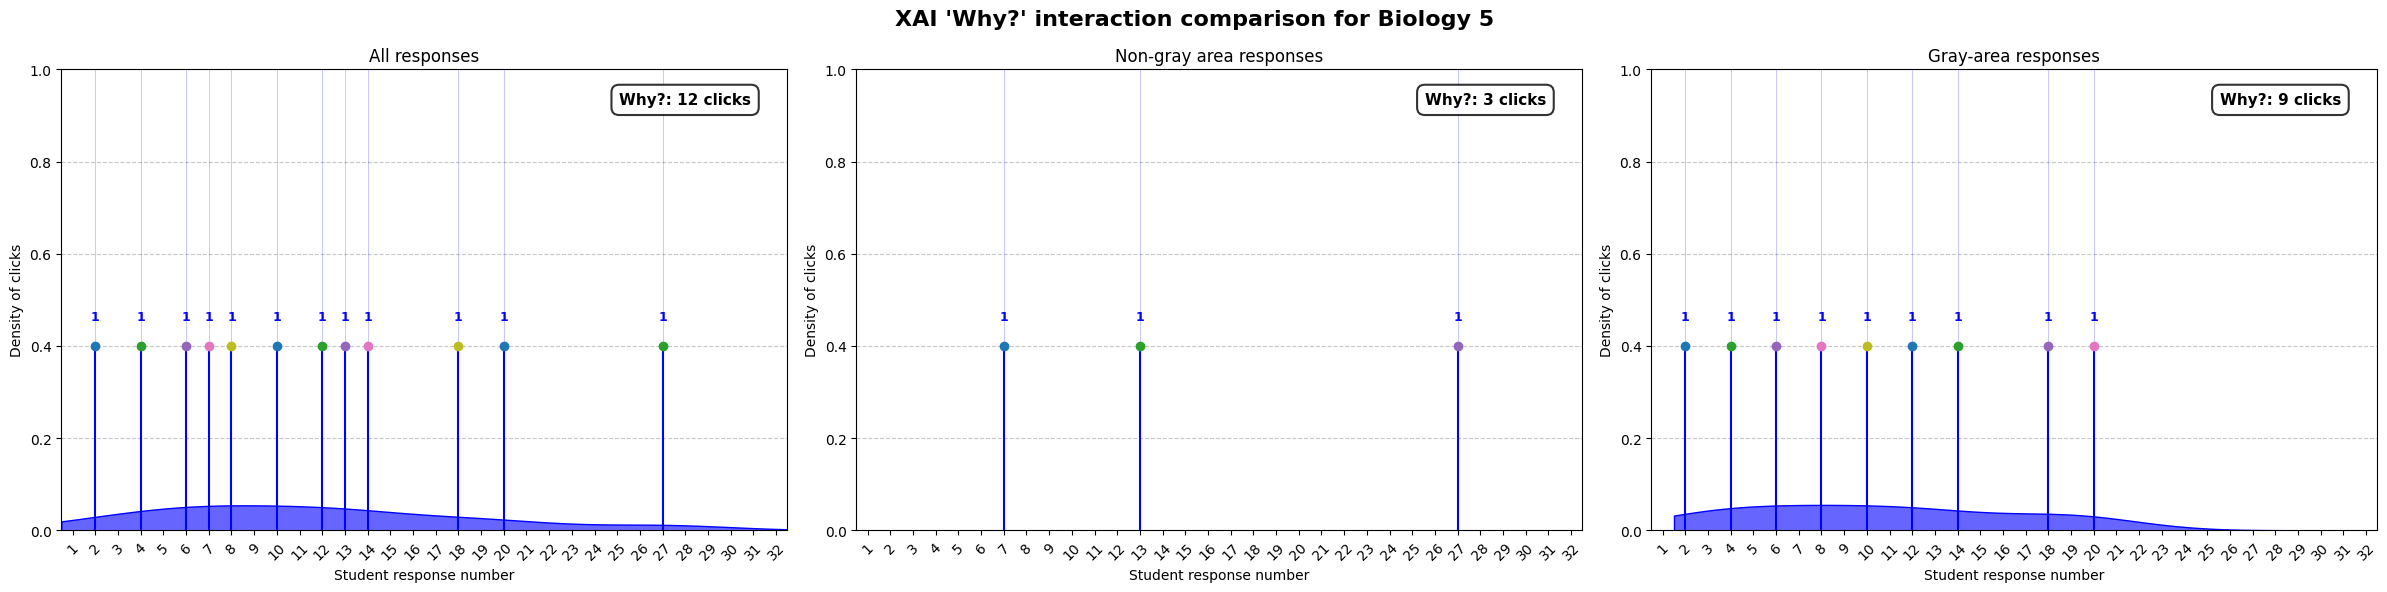

In [123]:
for name, df in bio_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    plt.suptitle(f"XAI 'Why?' interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Filter data
    df_odd = df[df['studentId'] % 2 == 1]
    df_even = df[df['studentId'] % 2 == 0]

    # Get consistent x-axis values from the full dataset
    min_student = df['student_nr'].min()
    max_student = 32  # Or df['student_nr'].max() if you want dynamic upper limit
    unique_students = sorted([s for s in df['student_nr'].unique() if s <= max_student])

    # Plot 1: All students
    plot_action_density(df, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax1)
    ax1.set_title(f"All Students ({name})")
    
    # Plot 2: Non-gray area students (odd IDs)
    plot_action_density(df_odd, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax2)
    ax2.set_title(f"Non-Gray Area Students ({name})")
    
    # Plot 3: Gray area students (even IDs)
    plot_action_density(df_even, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax3)
    ax3.set_title(f"Gray-Area Students ({name})")
    
    # Set consistent x-axis for all plots
    for ax, title in zip([ax1, ax2, ax3], 
                         [f"All responses", 
                          f"Non-gray area responses", 
                          f"Gray-area responses"]):
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [124]:
def plot_on_axis(df, ax, actions, participant_name):
    # Wrapper for plot_action_density to plot on a given axis
    plot_action_density(
        df, 
        participant=participant_name, 
        actions=actions, 
        max_student=32, 
        display_data=False, 
        show_plot=False, 
        ax=ax
    )

def create_comparison_dashboard(df, participant_name):
    """Create a dashboard with multiple plots for better comparison"""
    
    # Create figure with a grid of subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Set up a 2x2 grid (or adjust as needed)
    grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.3)
    
    # Filter data
    df_odd = df[df['studentId'] % 2 == 1]
    df_even = df[df['studentId'] % 2 == 0]
    
    # Add a big title for the entire figure
    fig.suptitle(f"Interaction Analysis for {participant_name}", fontsize=18, fontweight='bold', y=0.98)
    
    # Plot 1: All students "Waarom?"
    ax1 = fig.add_subplot(grid[0, 0])
    plot_on_axis(df, ax1, [filtered_actions[0]], participant_name)
    ax1.set_title(f"All Students - 'Waarom?' Clicks", fontweight='bold')
    
    # Plot 2: All students "Vergelijkbare antwoorden"
    ax2 = fig.add_subplot(grid[0, 1])
    plot_on_axis(df, ax2, [filtered_actions[2], filtered_actions[4]], participant_name)
    ax2.set_title(f"All Students - 'Vergelijkbare antwoorden' Clicks", fontweight='bold')
    
    # Plot 3: Non-gray area students
    ax3 = fig.add_subplot(grid[1, 0])
    plot_on_axis(df_odd, ax3, [filtered_actions[0]], participant_name)
    ax3.set_title(f"Non-Gray Area Students - 'Waarom?' Clicks", fontweight='bold')
    
    # Plot 4: Gray area students
    ax4 = fig.add_subplot(grid[1, 1])
    plot_on_axis(df_even, ax4, [filtered_actions[0]], participant_name)
    ax4.set_title(f"Gray Area Students - 'Waarom?' Clicks", fontweight='bold')
    
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    plt.show()
    
    return fig

## ECO interactions "waarom"

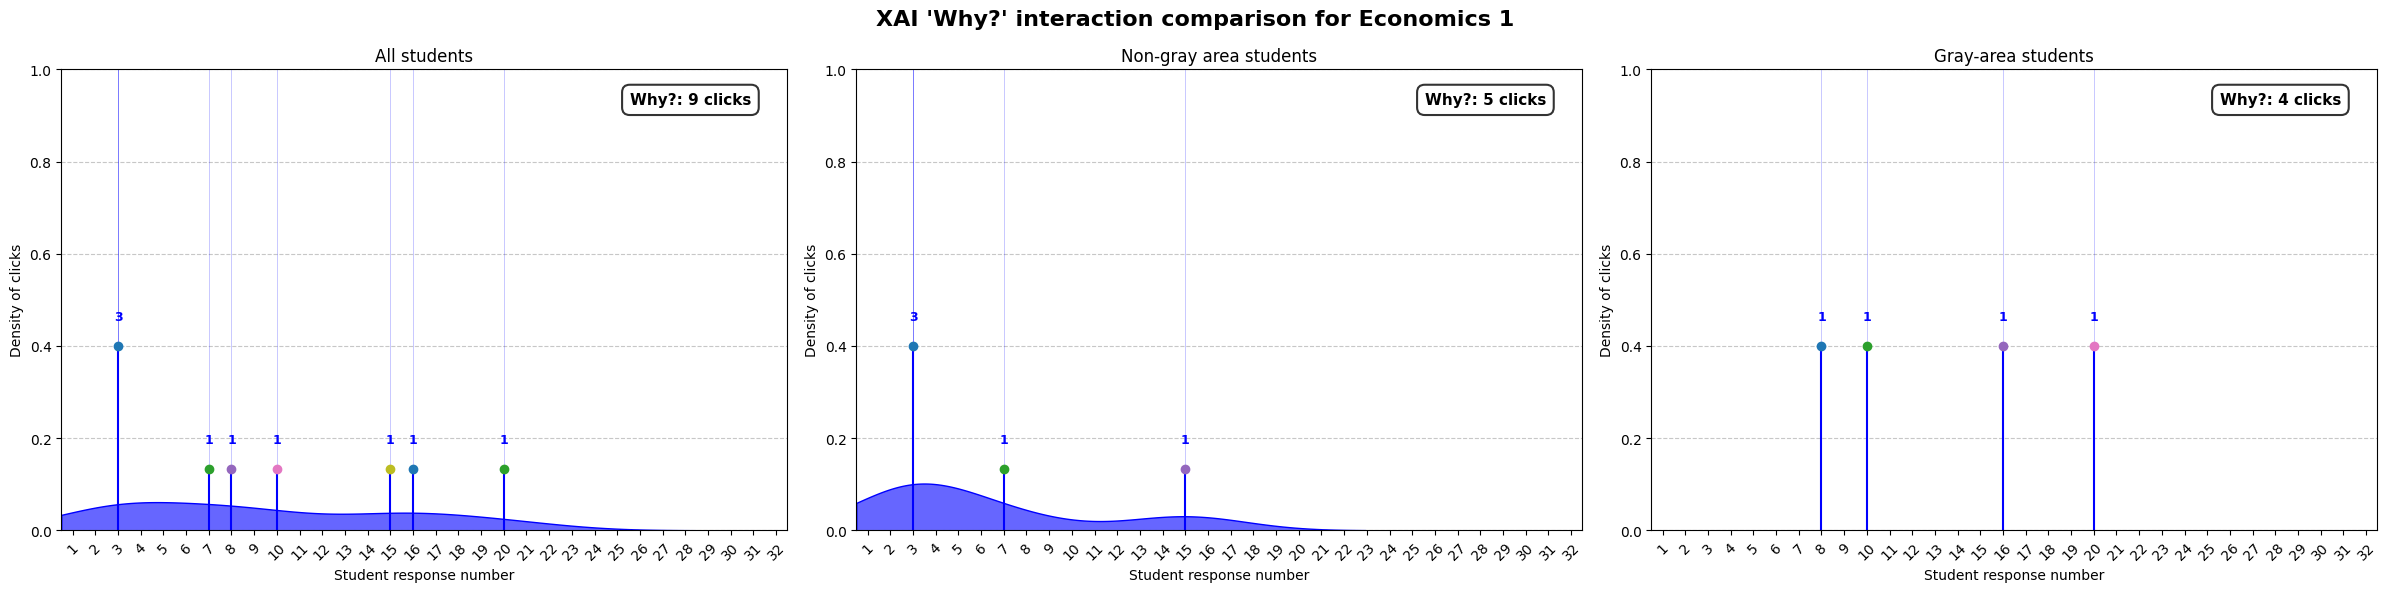

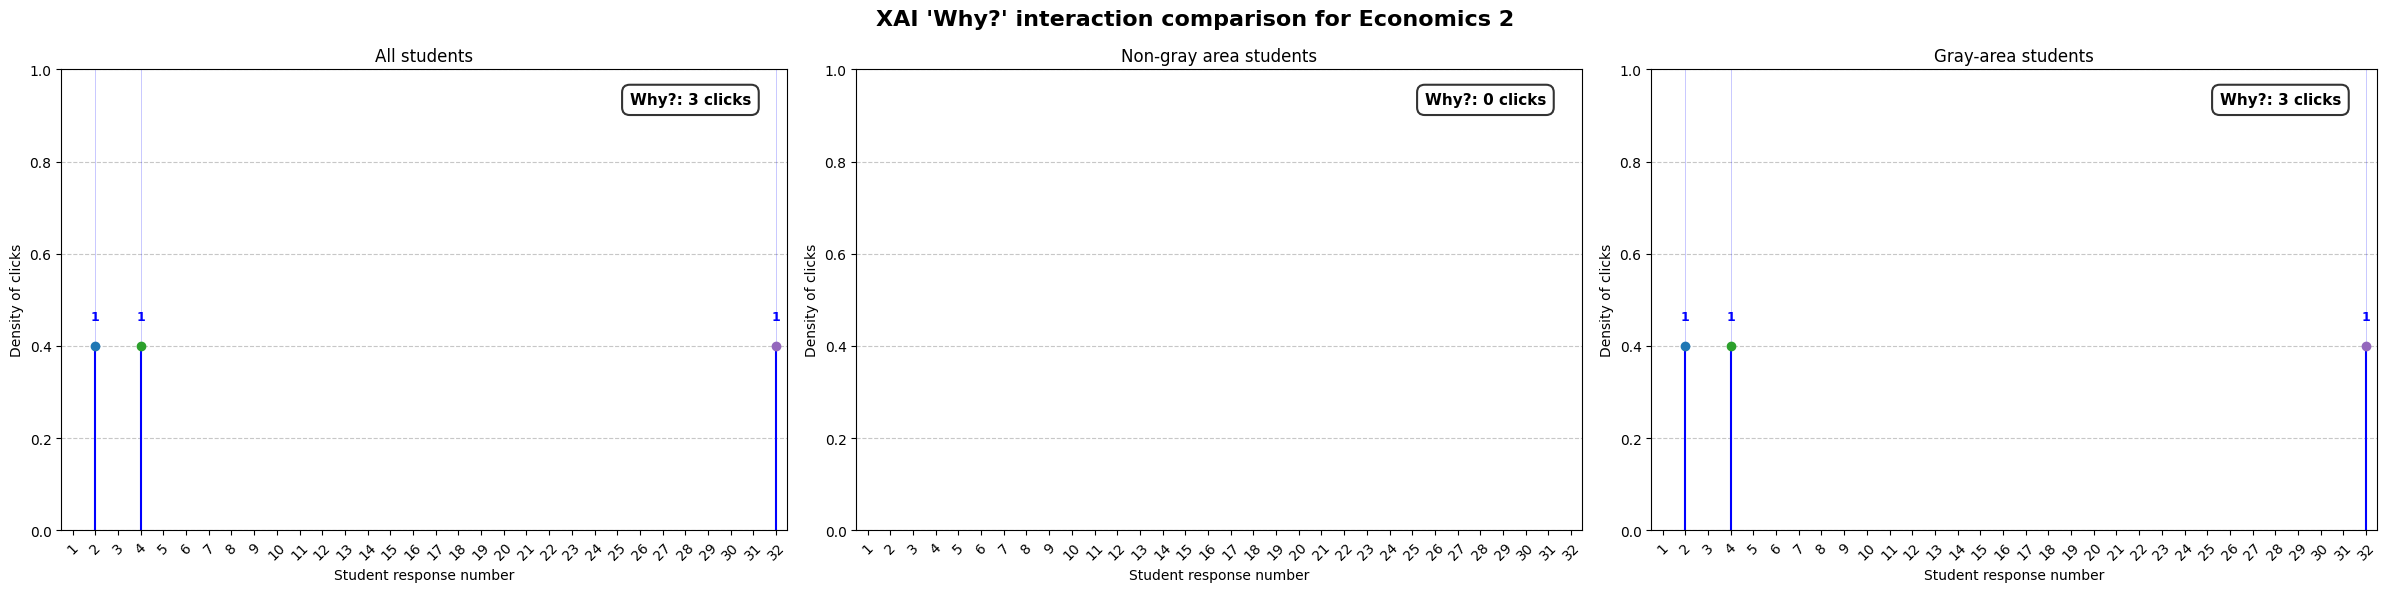

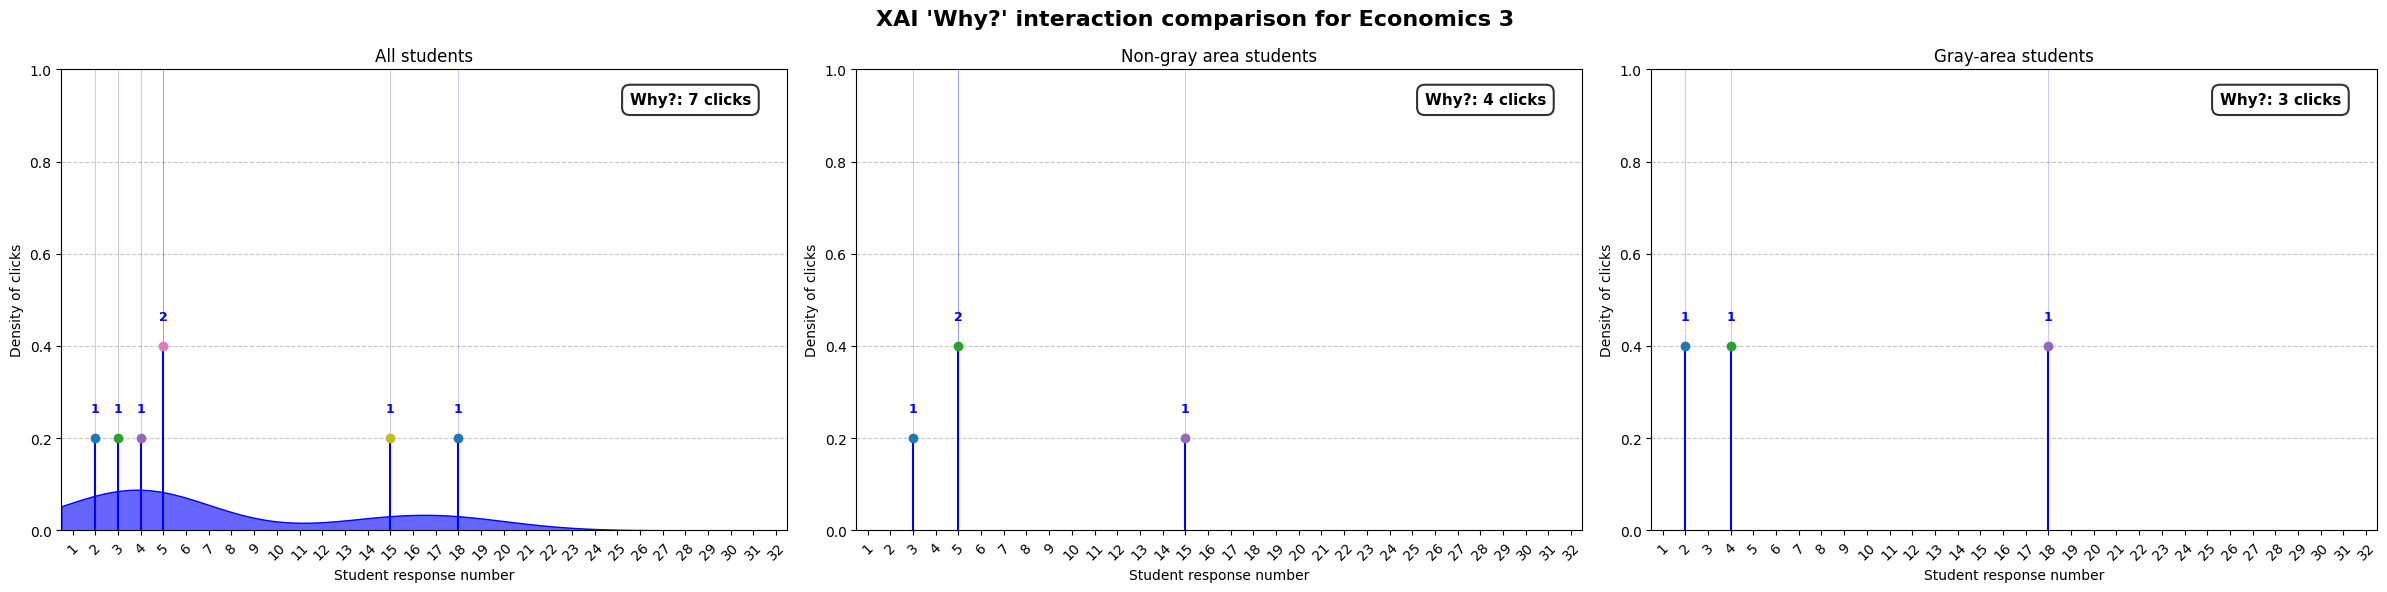

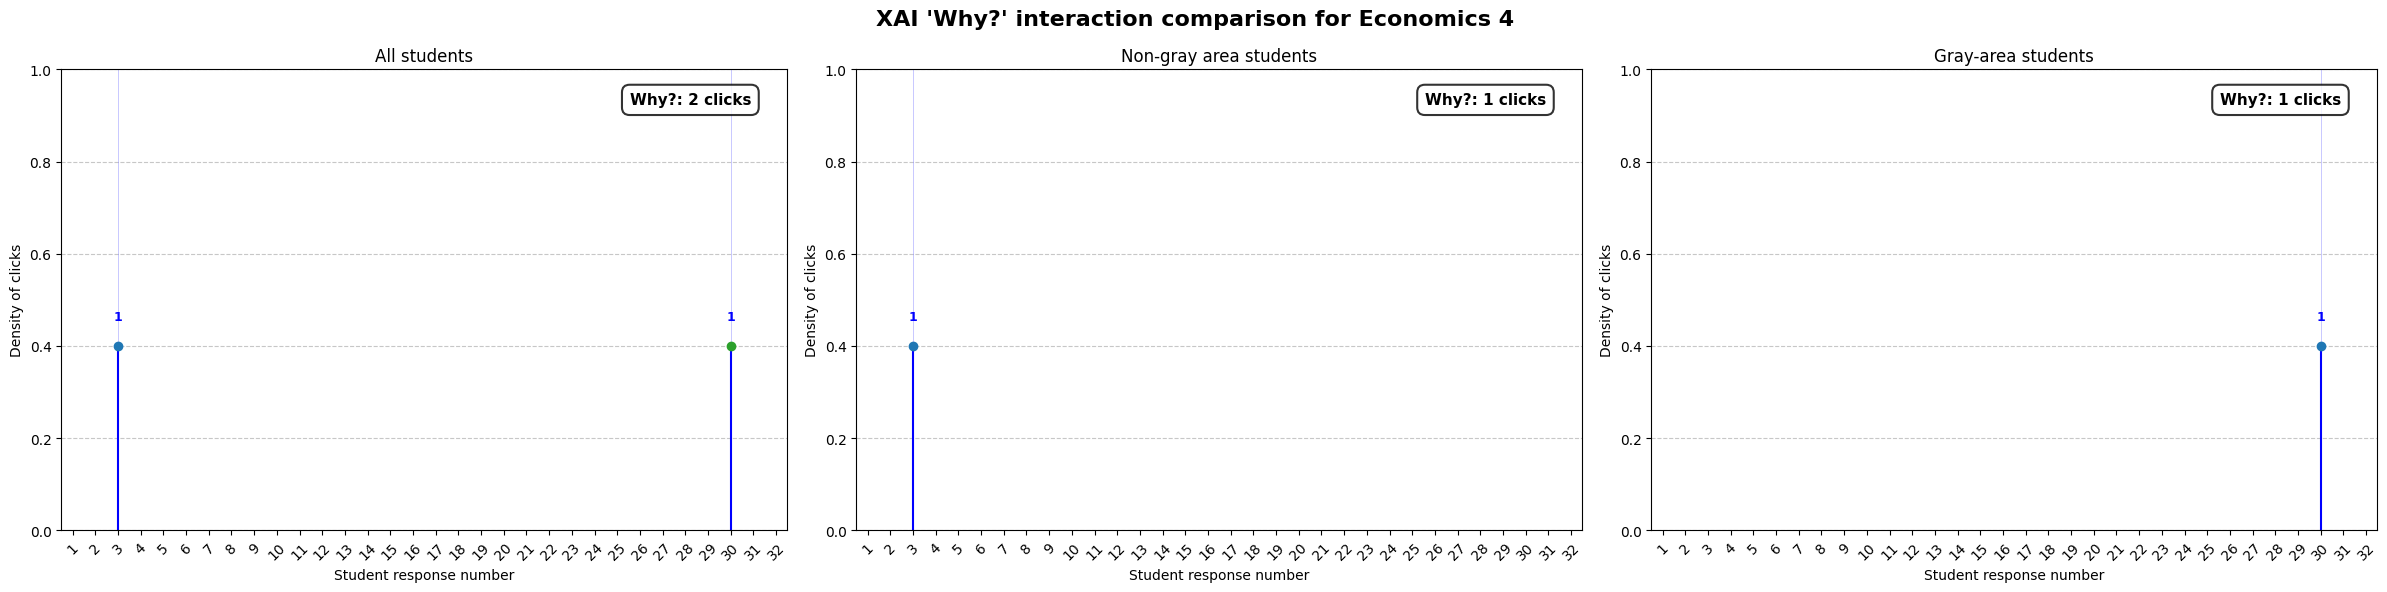

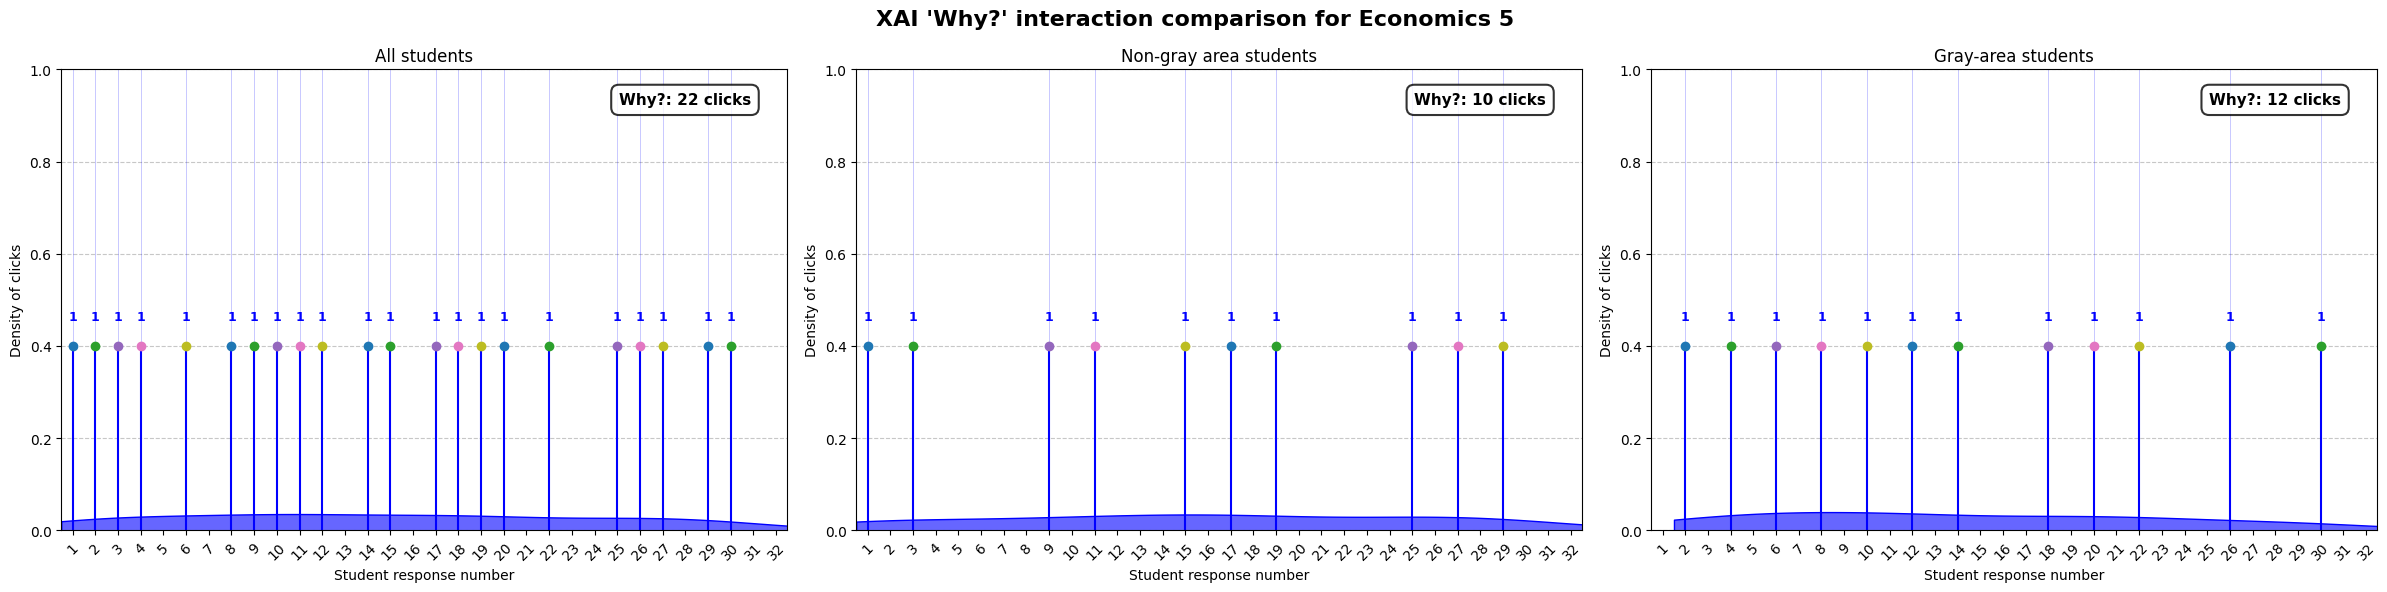

In [125]:
for name, df in eco_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    plt.suptitle(f"XAI 'Why?' interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Filter data
    df_odd = df[df['studentId'] % 2 == 1]
    df_even = df[df['studentId'] % 2 == 0]
    
    # Plot 1: All students
    plot_action_density(df, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax1)
    ax1.set_title(f"All Students ({name})")
    
    # Plot 2: Non-gray area students (odd IDs)
    plot_action_density(df_odd, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax2)
    ax2.set_title(f"Non-Gray Area Students ({name})")
    
    # Plot 3: Gray area students (even IDs)
    plot_action_density(df_even, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax3)
    ax3.set_title(f"Gray-Area Students ({name})")

    # Set consistent x-axis for all plots
    for ax, title in zip([ax1, ax2, ax3], 
                         [f"All students", 
                          f"Non-gray area students", 
                          f"Gray-area students"]):
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

## BIO interactions "vergelijkbare antwoorden"

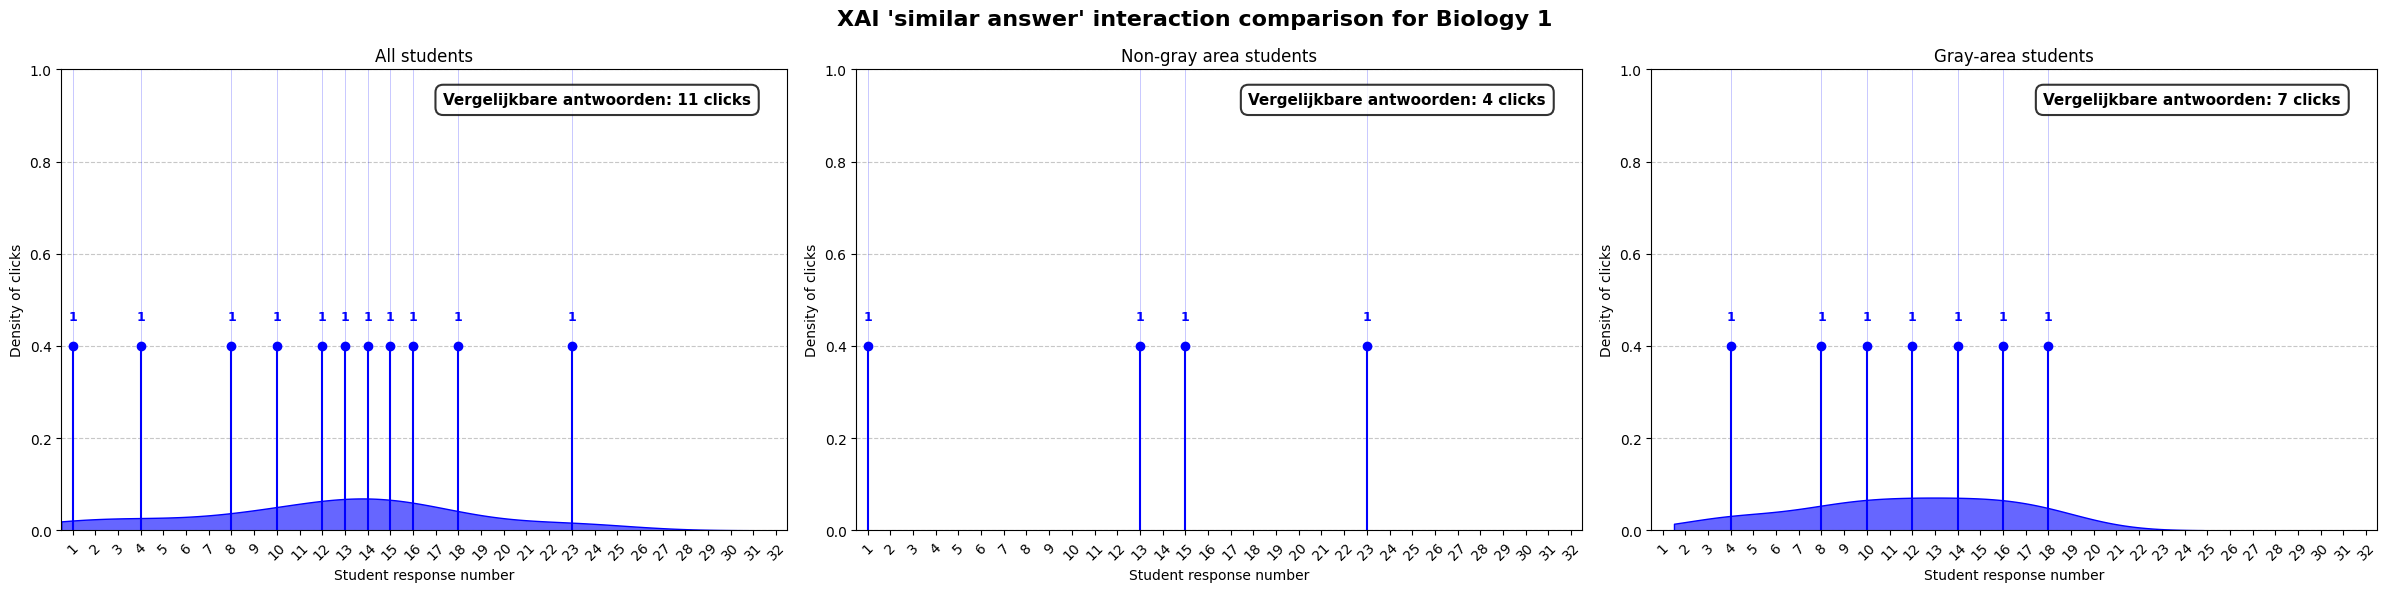

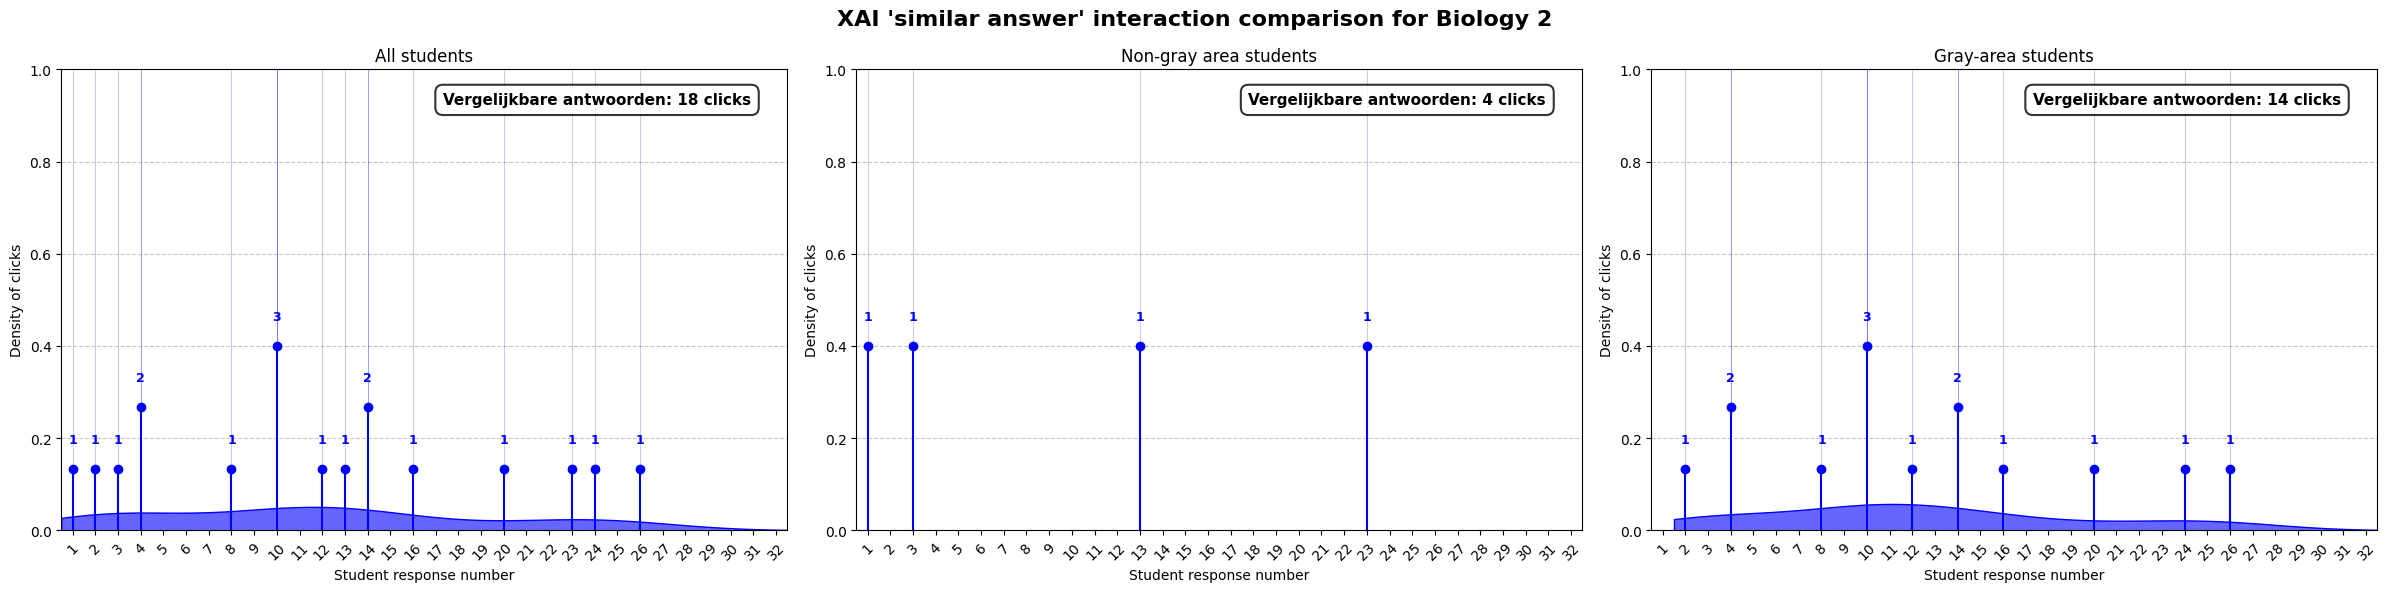

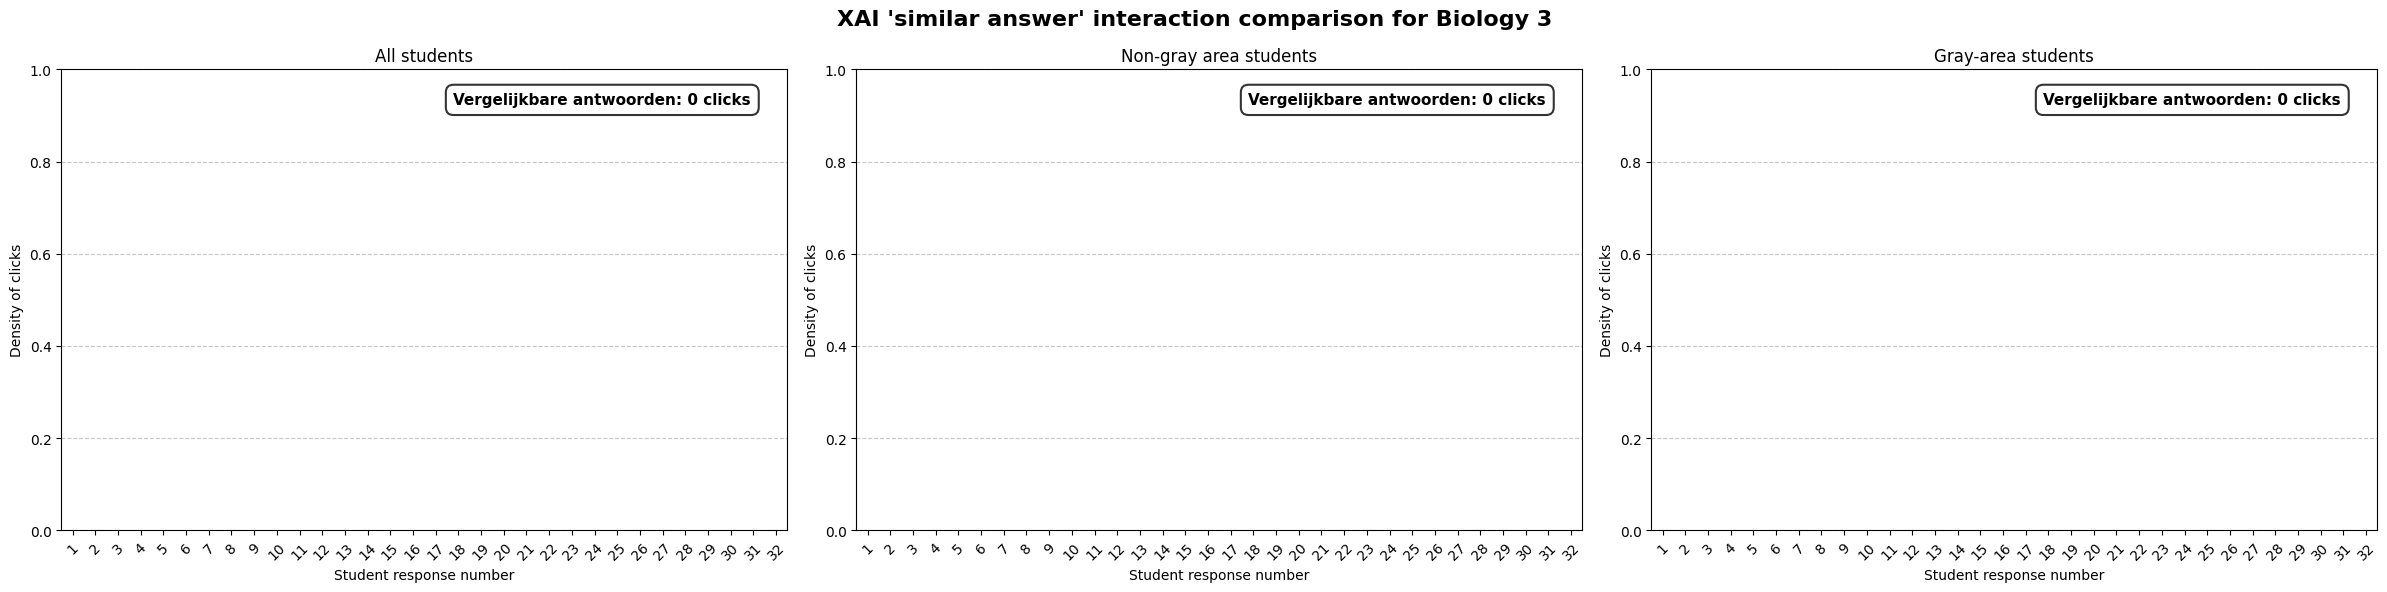

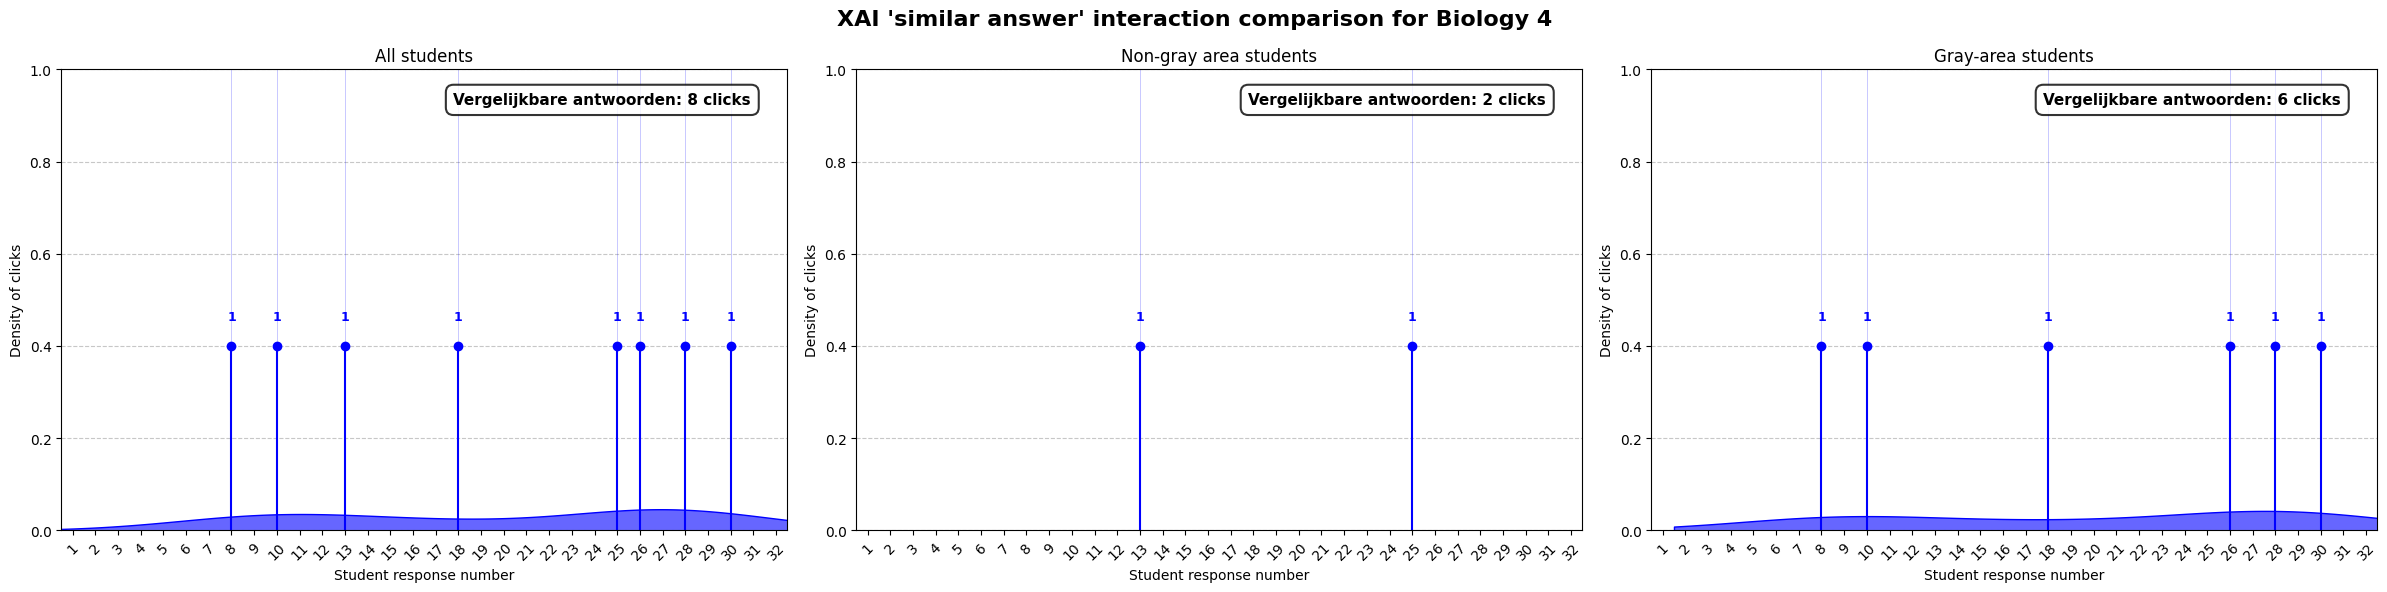

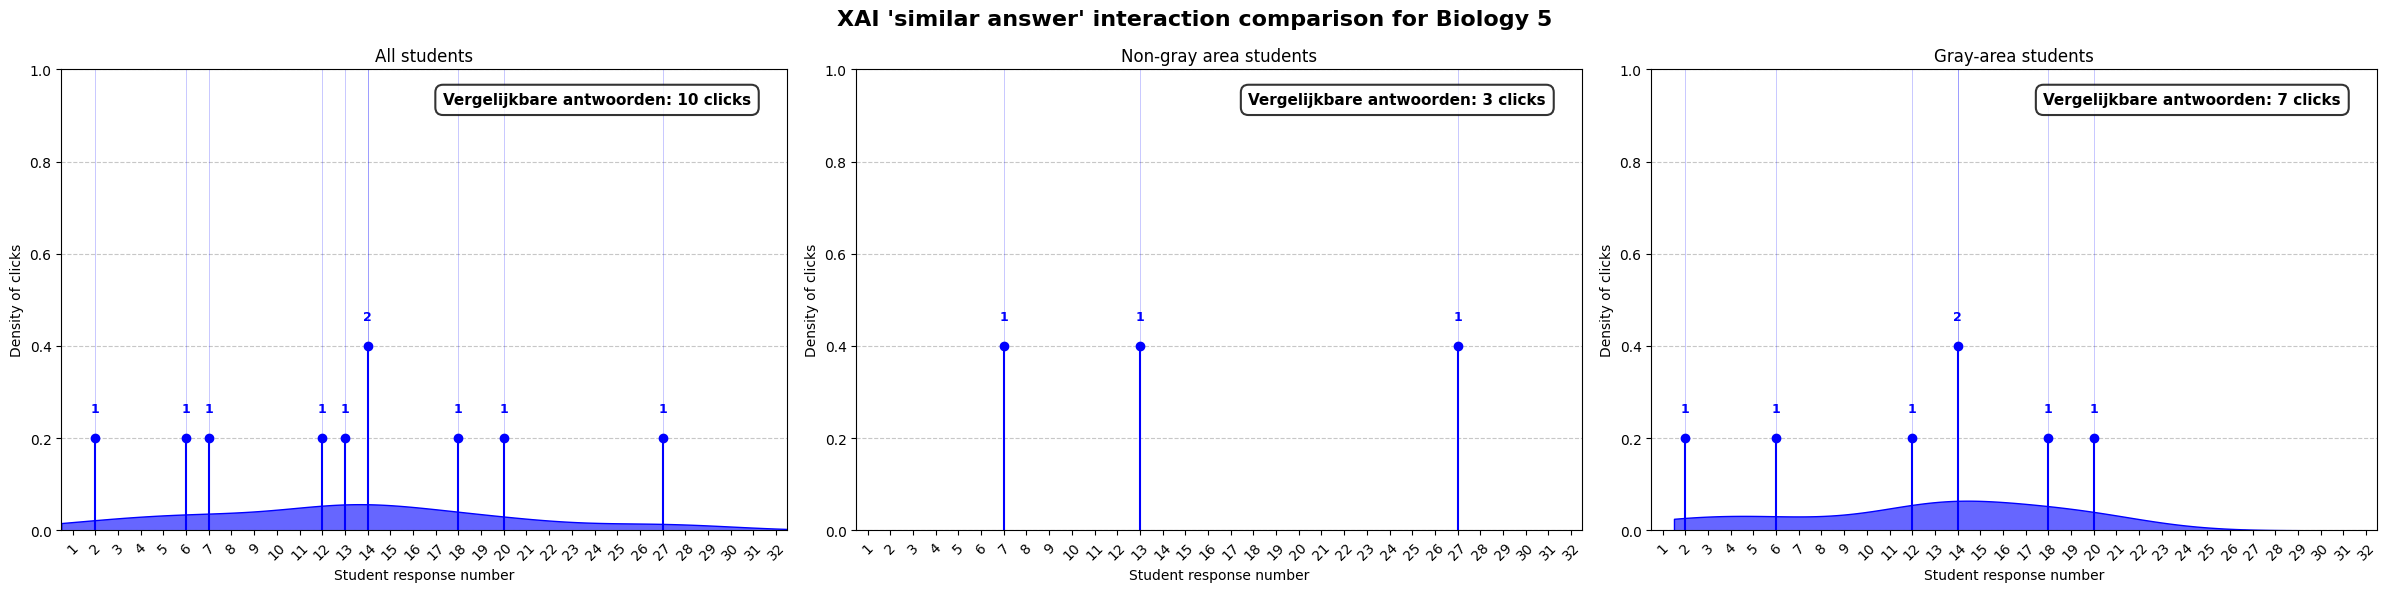

In [126]:
for name, df in bio_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    plt.suptitle(f"XAI 'similar answer' interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Filter data
    df_odd = df[df['studentId'] % 2 == 1]
    df_even = df[df['studentId'] % 2 == 0]
    
    # Plot 1: All students
    plot_action_density(df, participant=name, actions = [filtered_actions[2], filtered_actions[4]], max_student=32, 
                       display_data=False, show_plot=False, ax=ax1, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax1.set_title(f"All Students ({name})")
    
    # Plot 2: Non-gray area students (odd IDs)
    plot_action_density(df_odd, participant=name, actions = [filtered_actions[2], filtered_actions[4]],  max_student=32, 
                       display_data=False, show_plot=False, ax=ax2, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax2.set_title(f"Non-Gray Area Students ({name})")
    
    # Plot 3: Gray area students (even IDs)
    plot_action_density(df_even, participant=name, actions = [filtered_actions[2], filtered_actions[4]], max_student=32, 
                       display_data=False, show_plot=False, ax=ax3, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax3.set_title(f"Gray-Area Students ({name})")

    # Set consistent x-axis for all plots
    for ax, title in zip([ax1, ax2, ax3], 
                         [f"All students", 
                          f"Non-gray area students", 
                          f"Gray-area students"]):
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

## Eco interactions "meest vergelijkbare antwoorden"

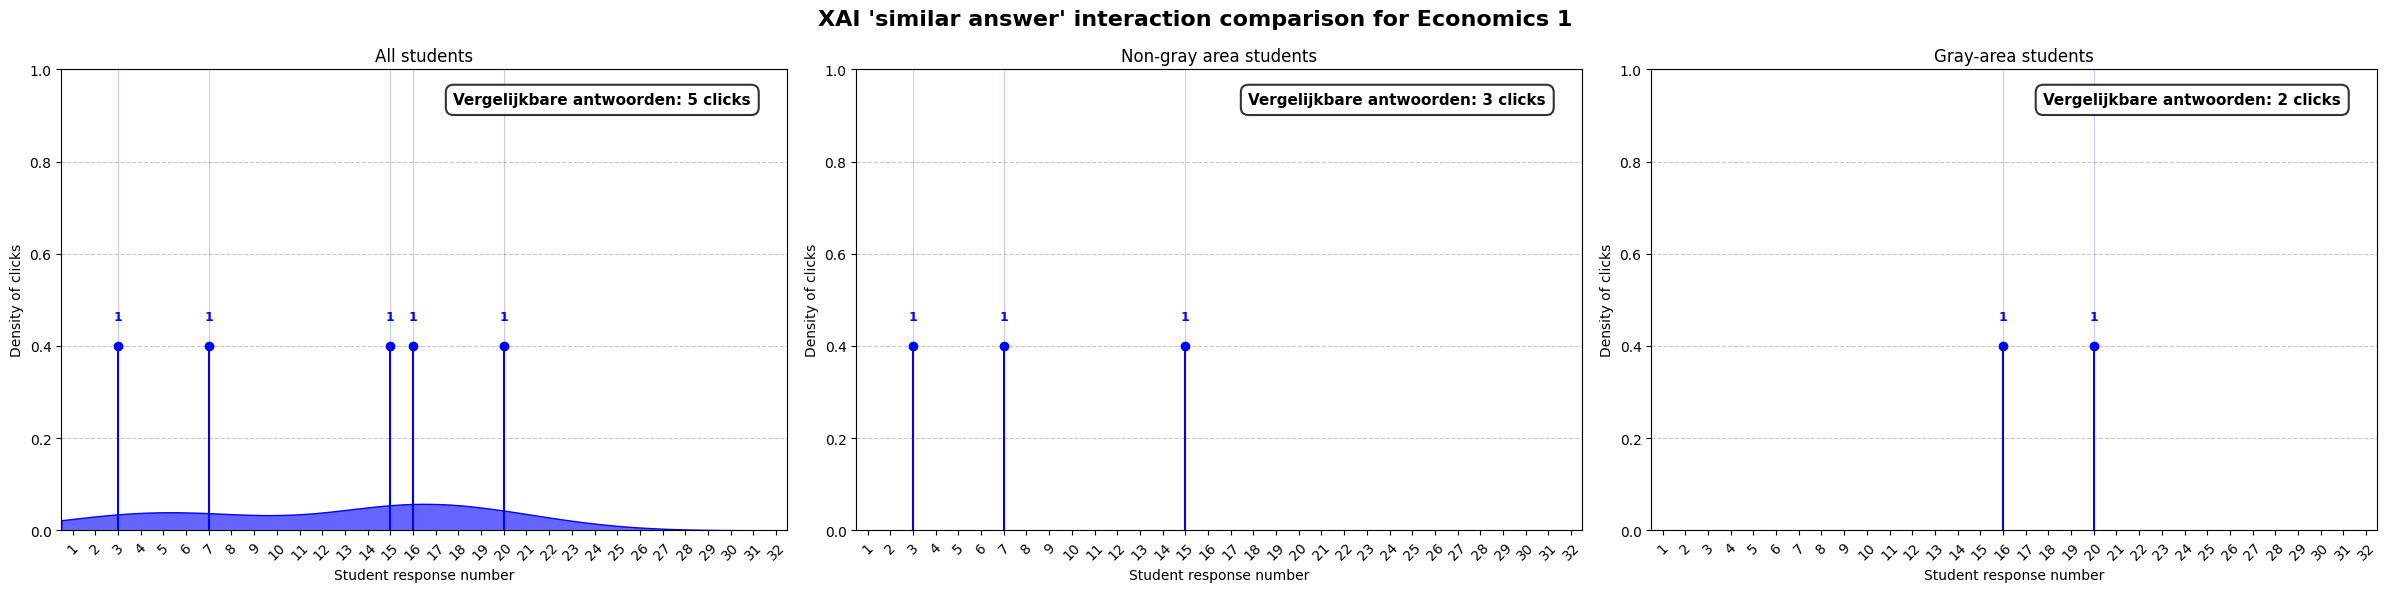

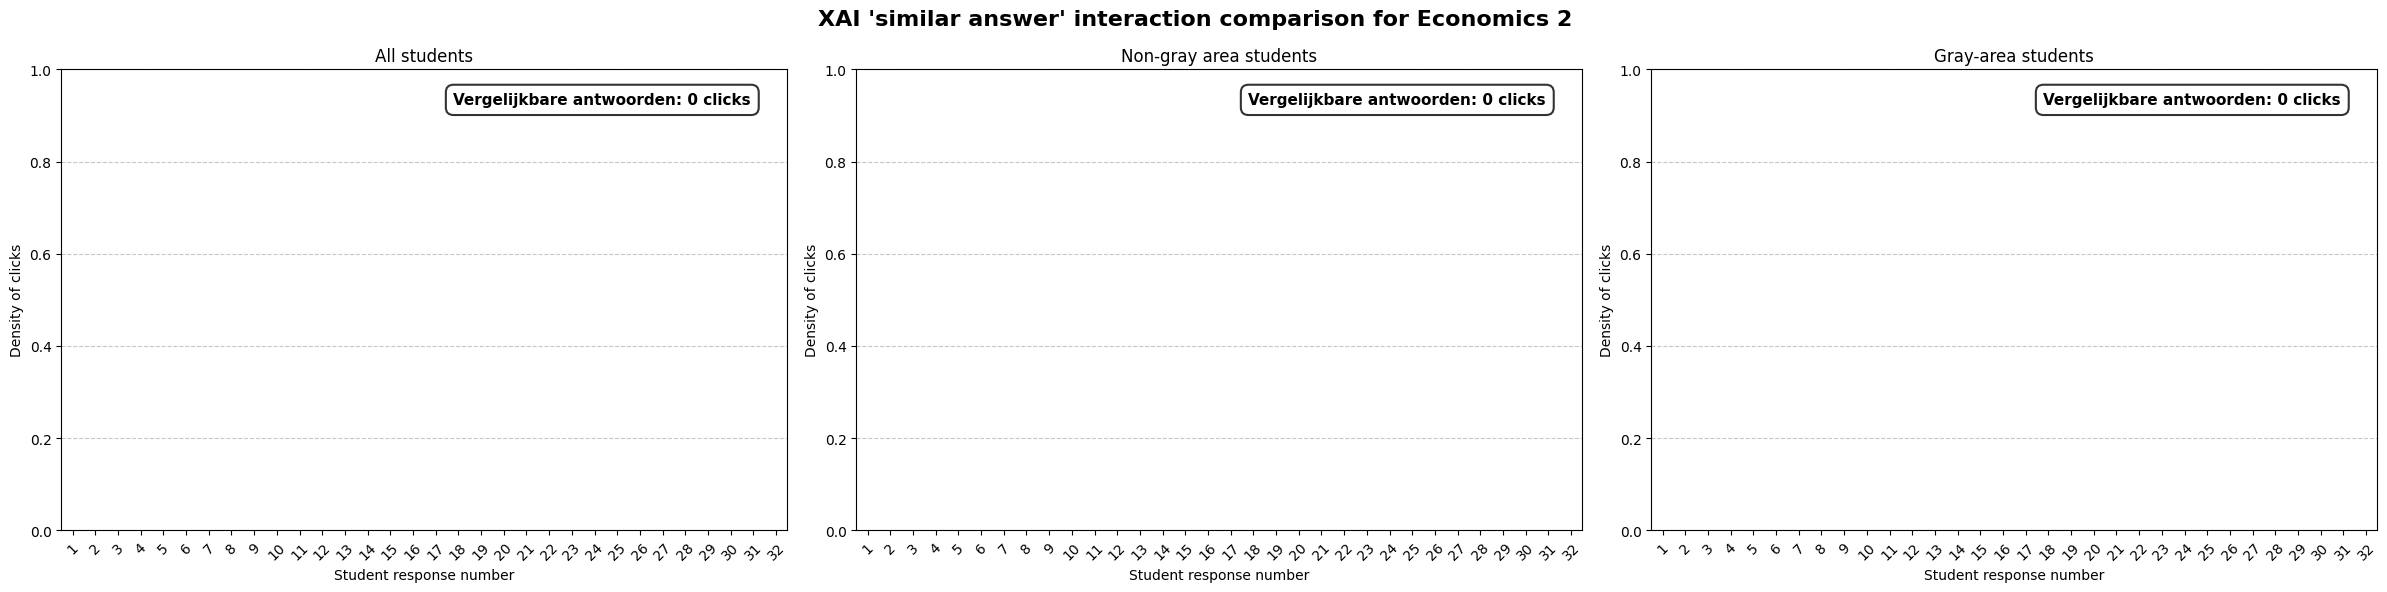

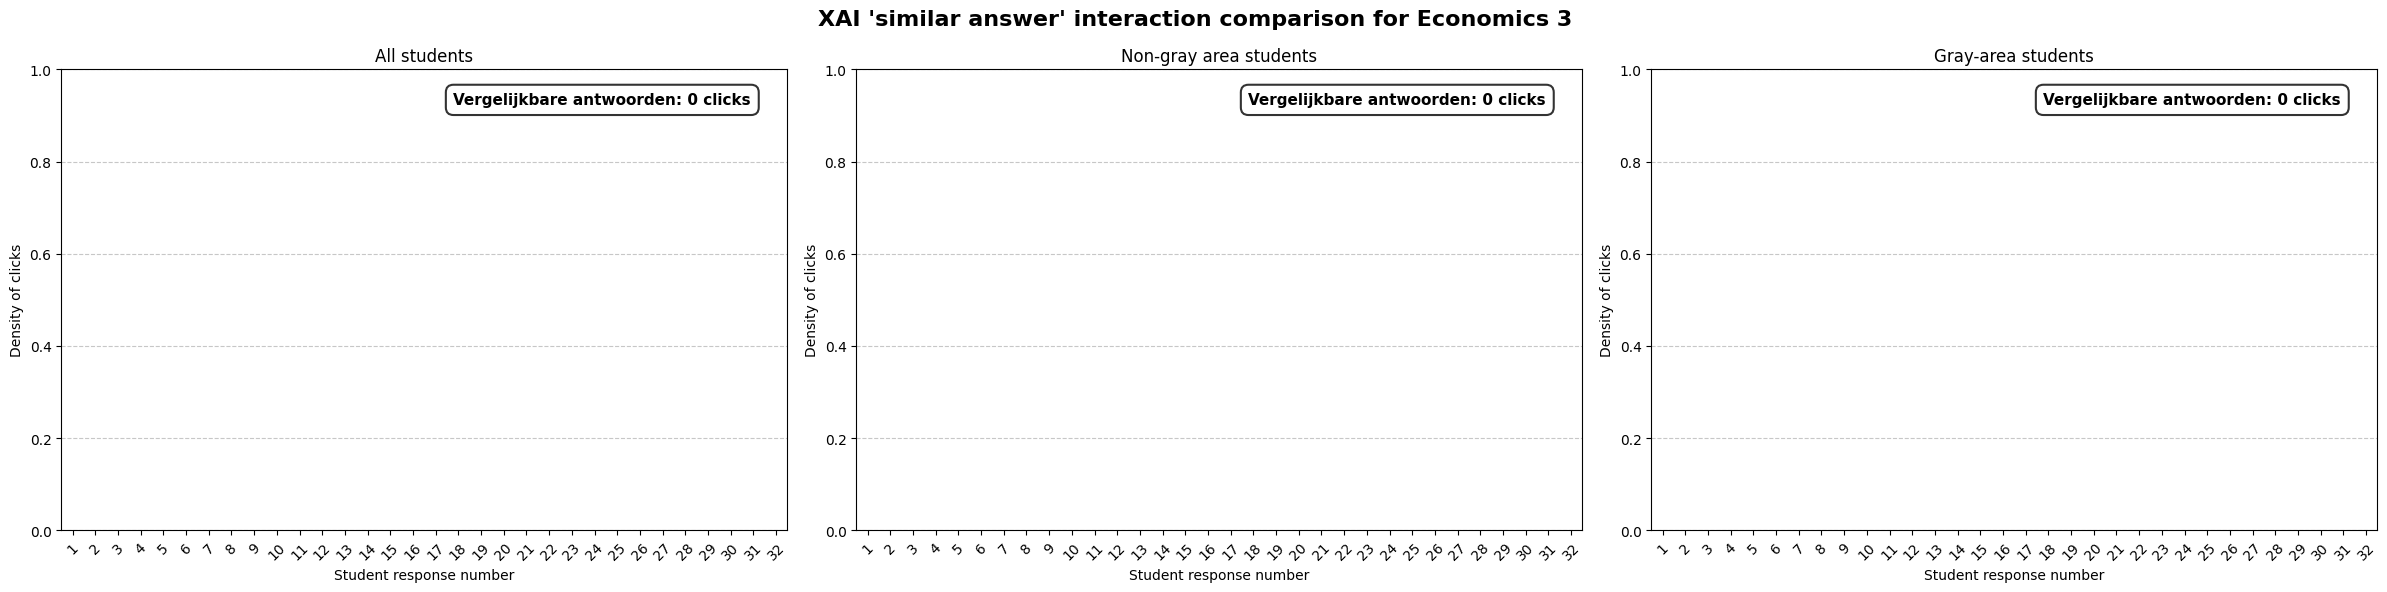

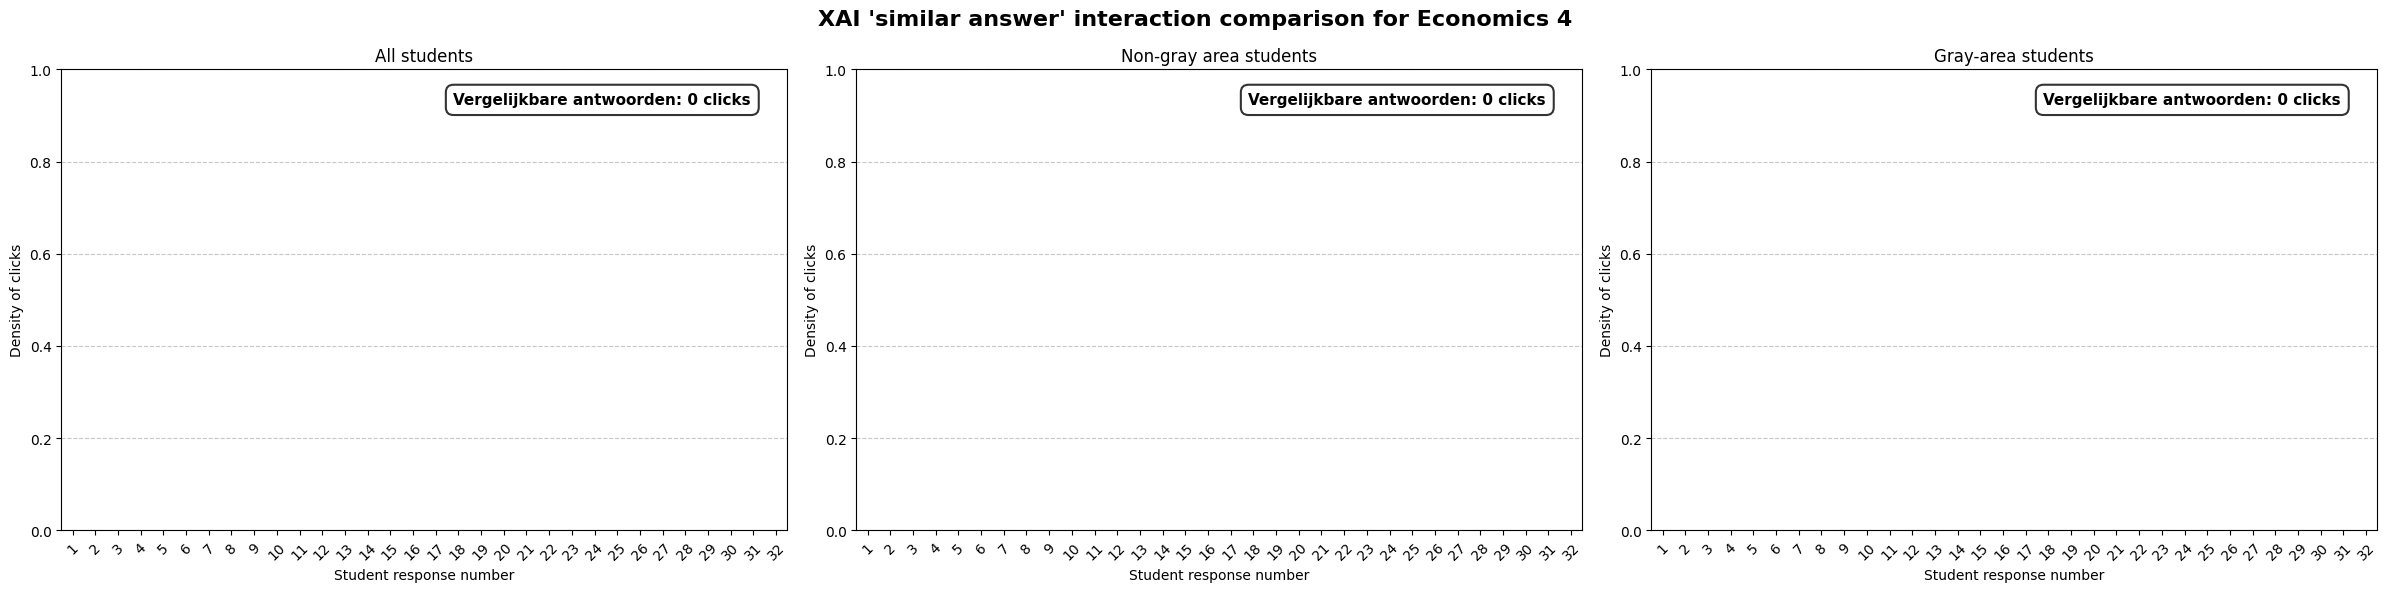

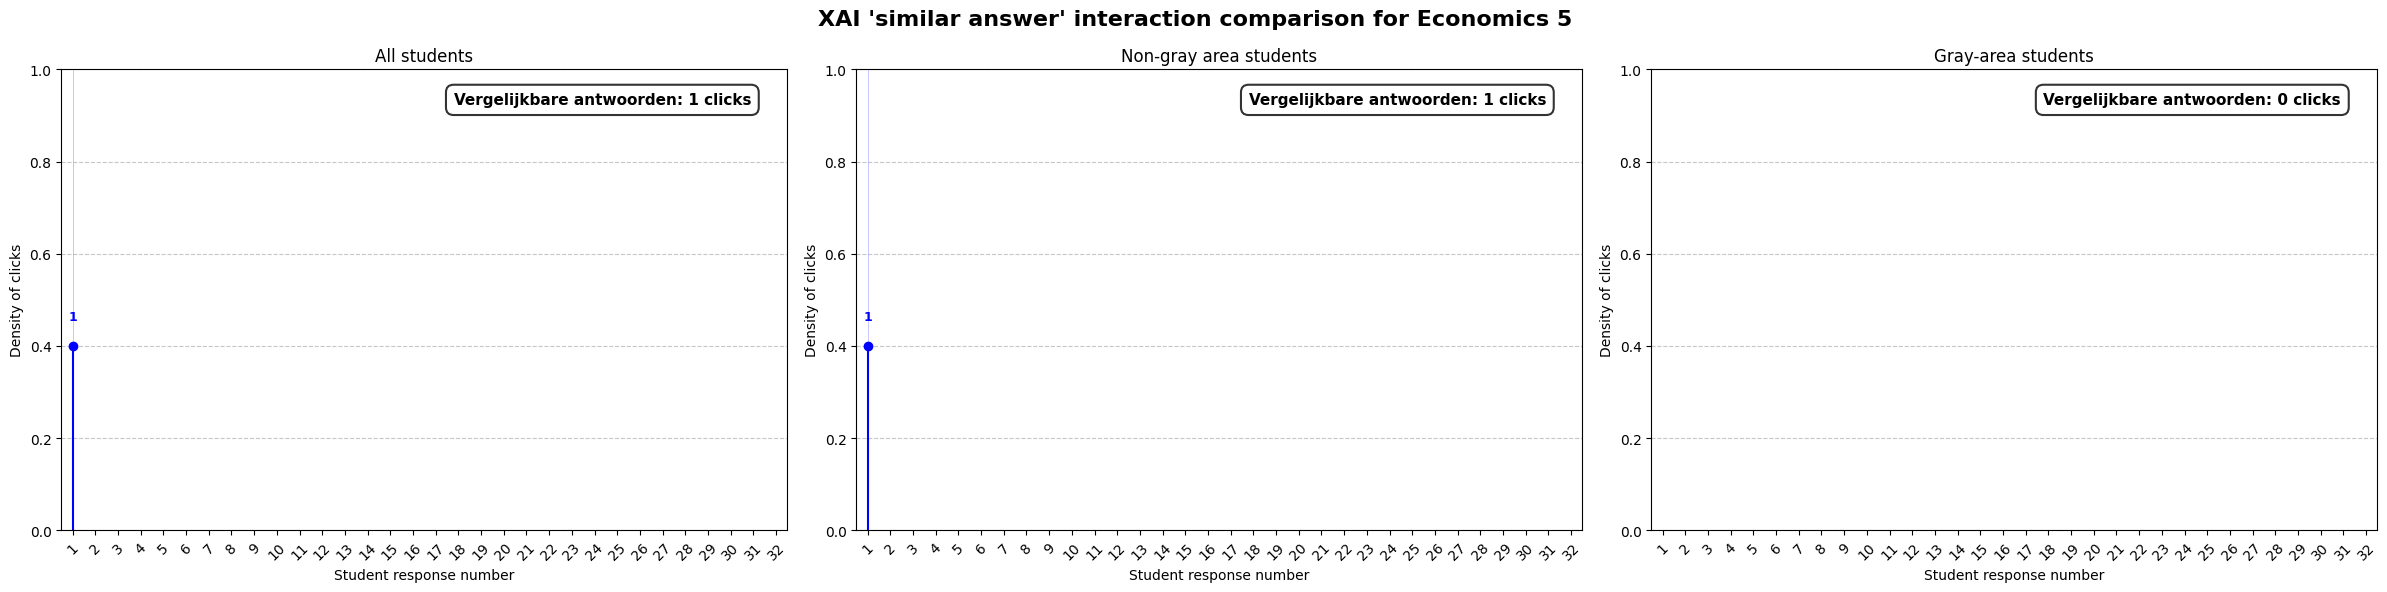

In [127]:
for name, df in eco_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    plt.suptitle(f"XAI 'similar answer' interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Filter data
    df_odd = df[df['studentId'] % 2 == 1]
    df_even = df[df['studentId'] % 2 == 0]
    
    # Plot 1: All students
    plot_action_density(df, participant=name, actions = [filtered_actions[2], filtered_actions[4]], max_student=32, 
                       display_data=False, show_plot=False, ax=ax1, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax1.set_title(f"All Students ({name})")
    
    # Plot 2: Non-gray area students (odd IDs)
    plot_action_density(df_odd, participant=name, actions = [filtered_actions[2], filtered_actions[4]],  max_student=32, 
                       display_data=False, show_plot=False, ax=ax2, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax2.set_title(f"Non-Gray Area Students ({name})")
    
    # Plot 3: Gray area students (even IDs)
    plot_action_density(df_even, participant=name, actions = [filtered_actions[2], filtered_actions[4]], max_student=32, 
                       display_data=False, show_plot=False, ax=ax3, combine_actions=True, combined_label="Vergelijkbare antwoorden")
    ax3.set_title(f"Gray-Area Students ({name})")

    # Set consistent x-axis for all plots
    for ax, title in zip([ax1, ax2, ax3], 
                         [f"All students", 
                          f"Non-gray area students", 
                          f"Gray-area students"]):
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

### Side-by-side why and similar answer interaction 

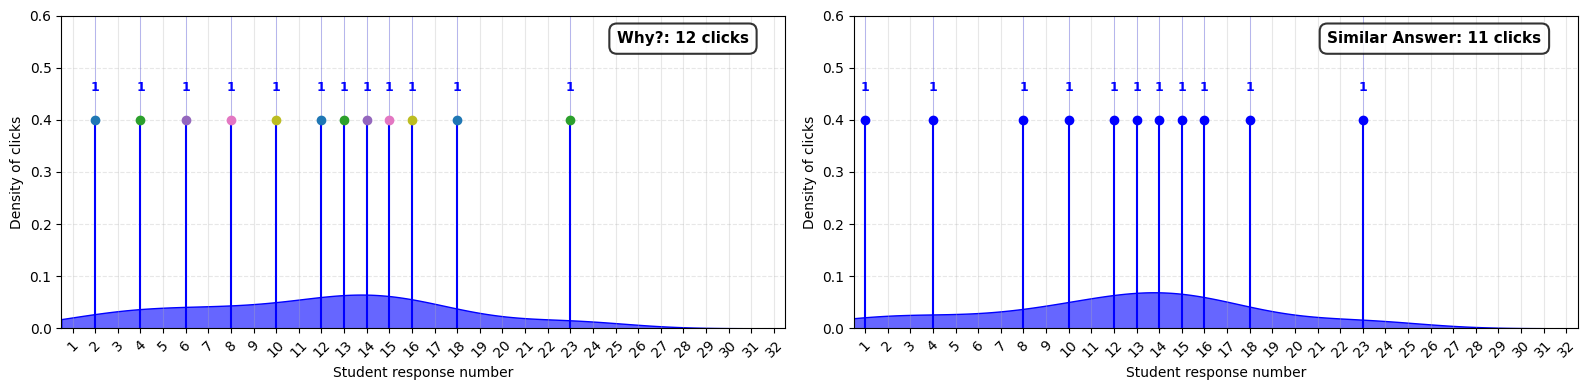

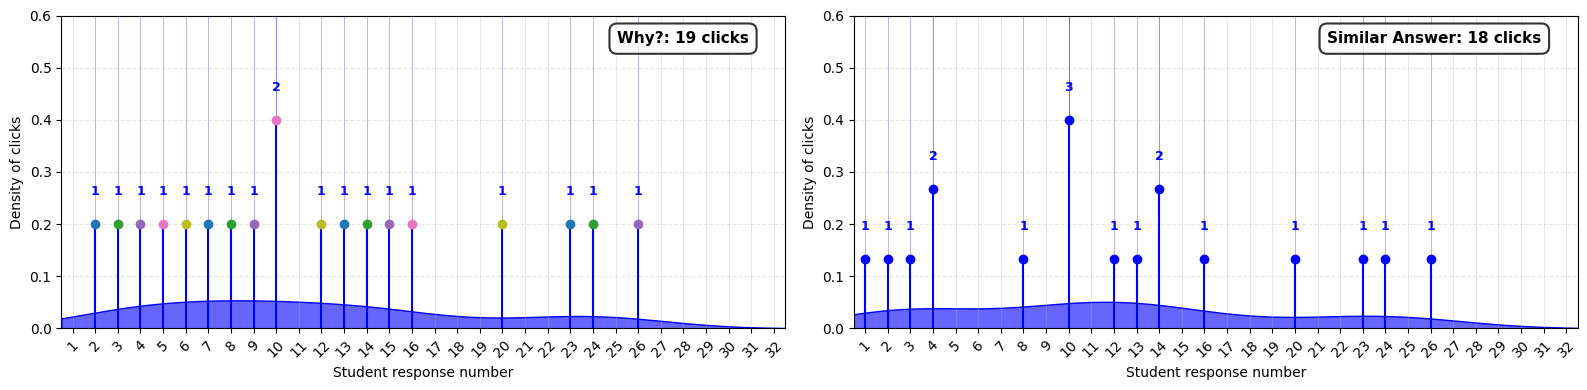

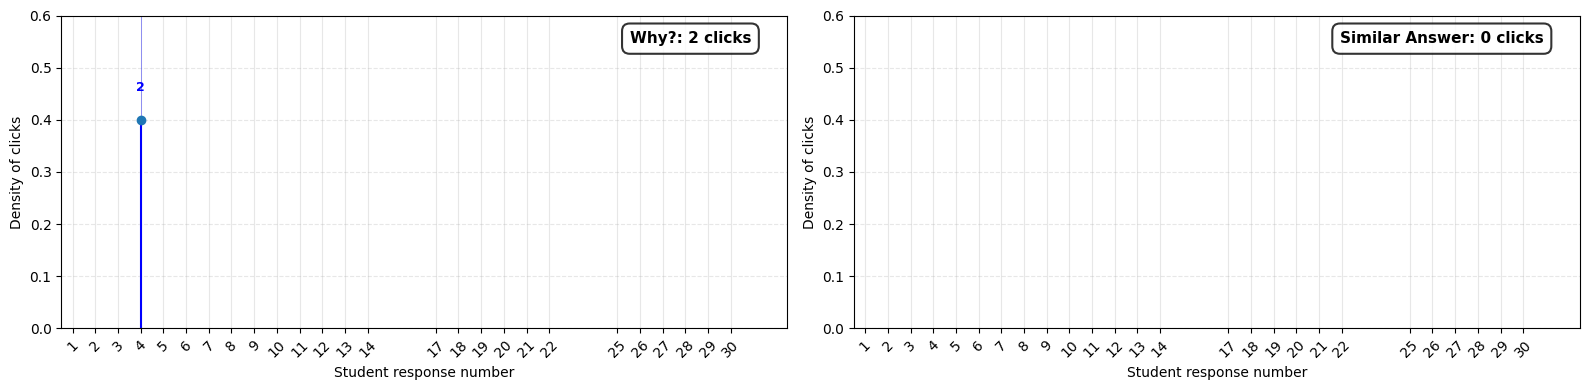

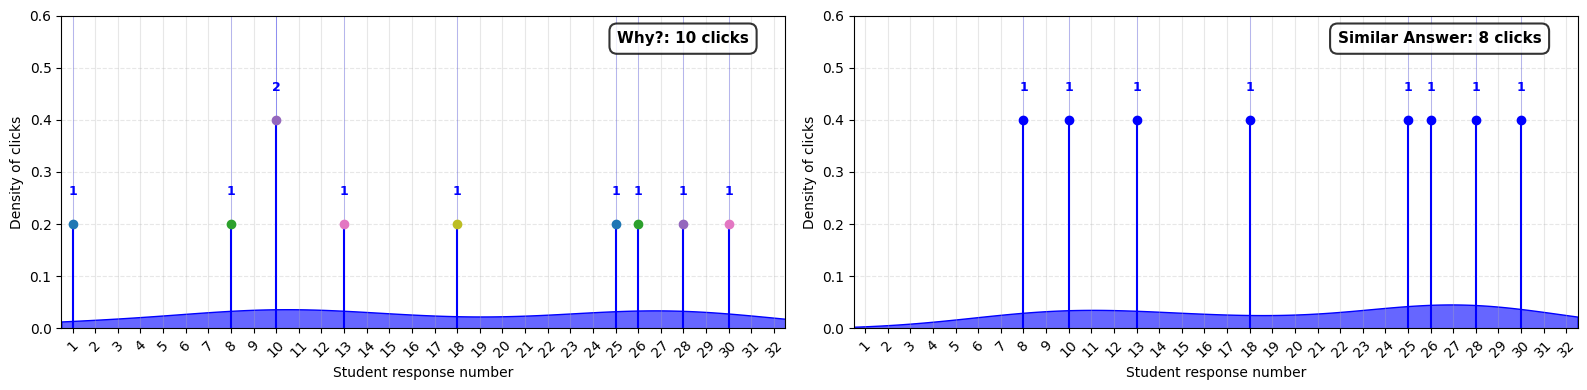

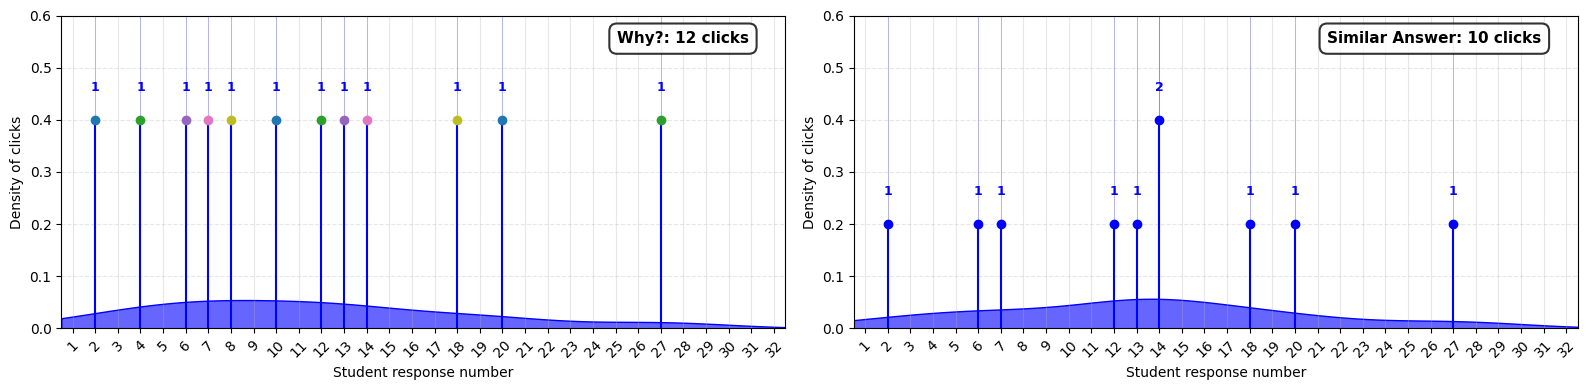

In [ ]:
for name, df in bio_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    plt.suptitle(f"XAI interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Get consistent x-axis values from the full dataset
    min_student = df['student_nr'].min()
    max_student = 32  # Or df['student_nr'].max() if you want dynamic upper limit
    unique_students = sorted([s for s in df['student_nr'].unique() if s <= max_student])

    # Plot 1: "Why?" interactions for all students
    plot_action_density(df, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax1)
    ax1.set_title(f'"Why?" button interactions')
    
    # Plot 2: "Similar Answer" interactions for all students
    plot_action_density(df, participant=name, 
                      actions=[filtered_actions[2], filtered_actions[4]], 
                      max_student=32, display_data=False, show_plot=False, 
                      ax=ax2, combine_actions=True, combined_label="Similar Answer")
    ax2.set_title(f'"Similar Answer" button interactions')
    
    # Set consistent x-axis for all plots
    for ax in [ax1, ax2]:
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_ylim(0, 0.6)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.grid(True, alpha=0.3)
    
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()

    filename = f"Int_plots/{name.replace(' ', '_')}_interactions.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

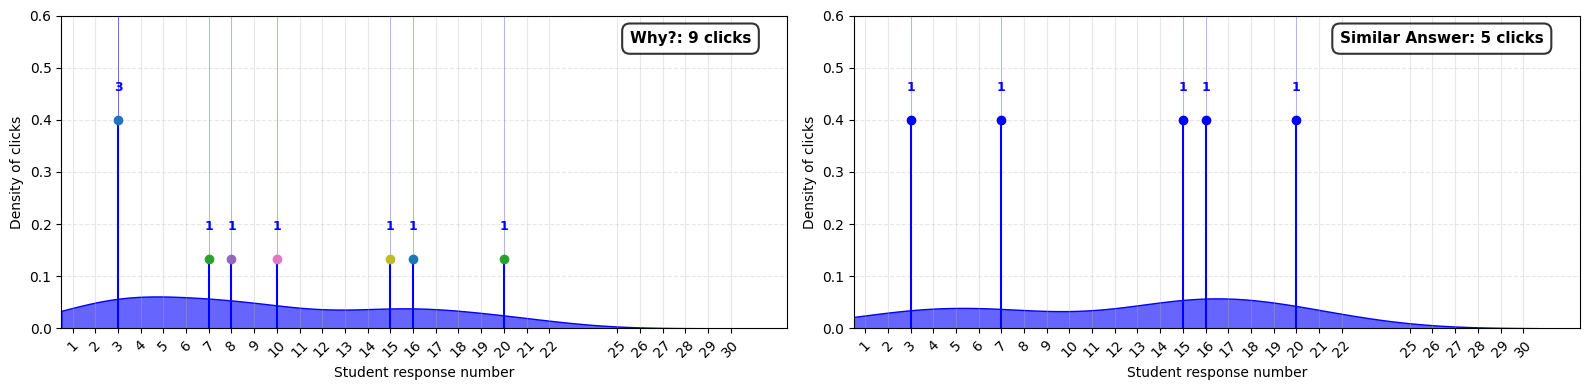

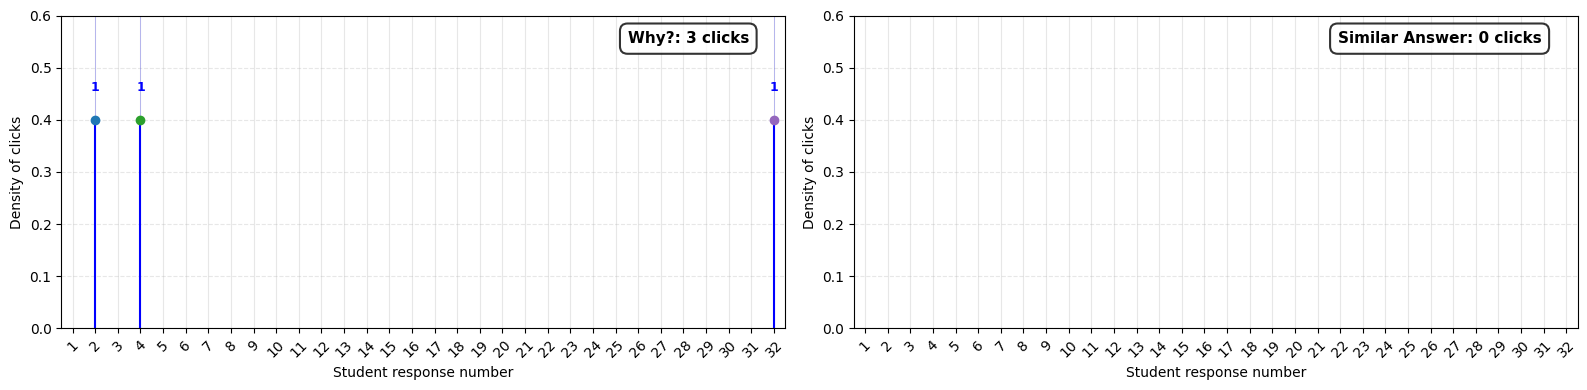

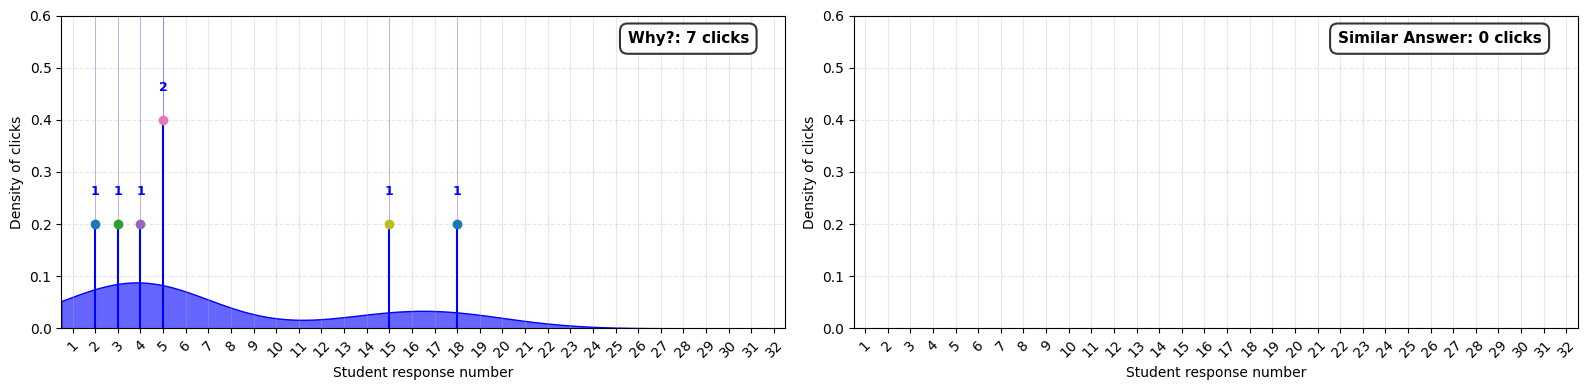

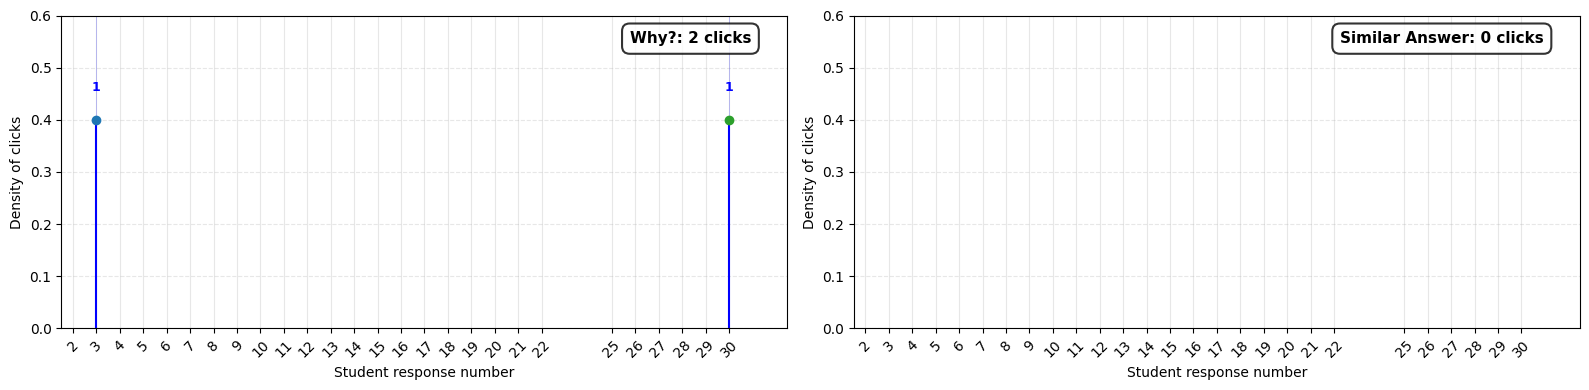

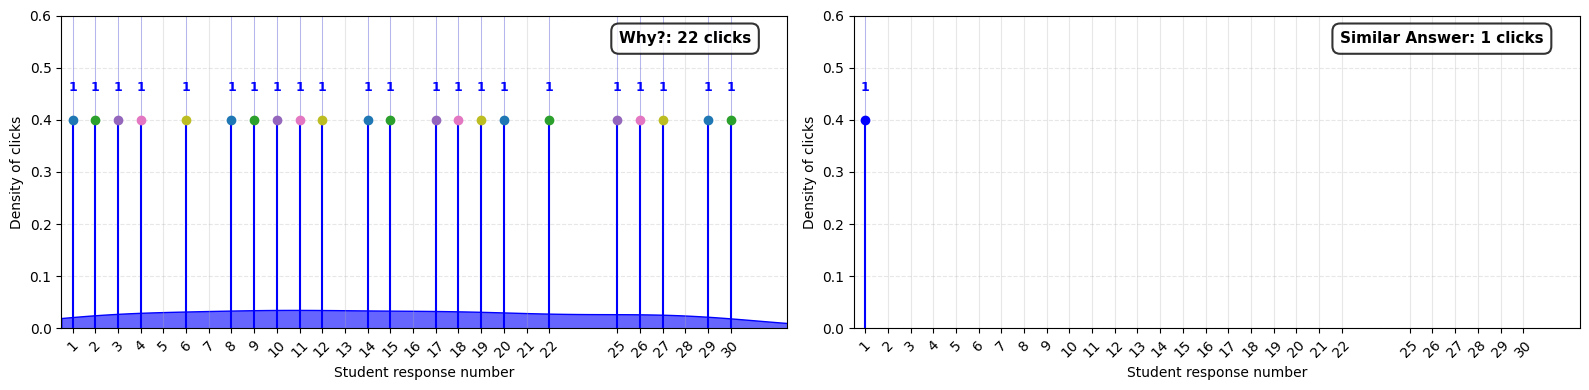

In [ ]:
for name, df in eco_datasets.items():
    df = pre_process_df(df)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    plt.suptitle(f"XAI interaction comparison for {name}", fontsize=16, fontweight='bold')
    
    # Get consistent x-axis values from the full dataset
    min_student = df['student_nr'].min()
    max_student = 32  # Or df['student_nr'].max() if you want dynamic upper limit
    unique_students = sorted([s for s in df['student_nr'].unique() if s <= max_student])

    # Plot 1: "Why?" interactions for all students
    plot_action_density(df, participant=name, max_student=32, 
                       display_data=False, show_plot=False, ax=ax1)
    ax1.set_title(f'"Why?" button interactions')
    
    # Plot 2: "Similar Answer" interactions for all students
    plot_action_density(df, participant=name, 
                      actions=[filtered_actions[2], filtered_actions[4]], 
                      max_student=32, display_data=False, show_plot=False, 
                      ax=ax2, combine_actions=True, combined_label="Similar Answer")
    ax2.set_title(f'"Similar Answer" button interactions')
    
    # Set consistent x-axis for all plots
    for ax in [ax1, ax2]:
        ax.set_xlim(min_student-0.5, max_student+0.5)
        ax.set_ylim(0, .6)
        ax.set_xticks(unique_students)
        ax.set_xticklabels([f"{s}" for s in unique_students], rotation=45)
        ax.grid(True, alpha=0.3)
    
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()

    filename = f"Int_plots/{name.replace(' ', '_')}_interactions.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

## Correlation interactions - load

In [56]:
def get_teacher_interaction_counts():
    """
    Analyze interaction patterns across teacher datasets and calculate interaction metrics.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame containing interaction metrics for each teacher with columns:
        - Teacher: Name identifier of the teacher (e.g., 'Biology 1')
        - Subject: Subject taught ('Biology' or 'Economics')
        - Why_Clicks: Total number of clicks on the "Why?" button
        - Why_Per_Student: Average number of "Why?" clicks per student response
        - Similar_Clicks: Total clicks on "Similar Answer" buttons (parts 1 and 2)
        - Similar_Per_Student: Average number of "Similar Answer" clicks per student
        - Total_Clicks: Combined total of all feature clicks (Why + Similar)
        - Total_Per_Student: Average total clicks per student response
    """
    interaction_data = []
    
    # Process Biology datasets
    for name, df in bio_datasets.items():
        processed_df = pre_process_df(df)
        
        # Count "Why?" clicks
        why_clicks = sum(processed_df['Waarom?'])
        
        # Count "Similar Answer" clicks (both parts)
        similar_clicks = sum(processed_df[filtered_actions[2]]) + sum(processed_df[filtered_actions[4]])
        
        # Get student count for calculating per-student metrics
        total_students = processed_df['student_nr'].nunique()
        
        interaction_data.append({
            'Teacher': name,
            'Subject': 'Biology',
            'Why_Clicks': why_clicks,
            'Why_Per_Student': why_clicks / total_students if total_students > 0 else 0,
            'Similar_Clicks': similar_clicks,
            'Similar_Per_Student': similar_clicks / total_students if total_students > 0 else 0,
            'Total_Clicks': why_clicks + similar_clicks,
            'Total_Per_Student': (why_clicks + similar_clicks) / total_students if total_students > 0 else 0
        })
    
    # Process Economics datasets
    for name, df in eco_datasets.items():
        processed_df = pre_process_df(df)
        
        # Count "Why?" clicks
        why_clicks = sum(processed_df['Waarom?'])
        
        # Count "Similar Answer" clicks
        similar_clicks = sum(processed_df[filtered_actions[2]]) + sum(processed_df[filtered_actions[4]])
        
        # Get student count
        total_students = processed_df['student_nr'].nunique()
        
        interaction_data.append({
            'Teacher': name,
            'Subject': 'Economics',
            'Why_Clicks': why_clicks,
            'Why_Per_Student': why_clicks / total_students if total_students > 0 else 0,
            'Similar_Clicks': similar_clicks,
            'Similar_Per_Student': similar_clicks / total_students if total_students > 0 else 0,
            'Total_Clicks': why_clicks + similar_clicks,
            'Total_Per_Student': (why_clicks + similar_clicks) / total_students if total_students > 0 else 0
        })
    
    return pd.DataFrame(interaction_data)

In [57]:
interaction_data =  get_teacher_interaction_counts()
display(interaction_data)

,Teacher,Subject,Why_Clicks,Why_Per_Student,Similar_Clicks,Similar_Per_Student,Total_Clicks,Total_Per_Student
0,Biology 1,Biology,12,0.375000,11,0.343750,23,0.718750
1,Biology 2,Biology,19,0.593750,18,0.562500,37,1.156250
2,Biology 3,Biology,2,0.076923,0,0.000000,2,0.076923
3,Biology 4,Biology,10,0.312500,8,0.250000,18,0.562500
4,Biology 5,Biology,12,0.375000,10,0.312500,22,0.687500
5,Economics 1,Economics,9,0.321429,5,0.178571,14,0.500000
6,Economics 2,Economics,3,0.093750,0,0.000000,3,0.093750
7,Economics 3,Economics,7,0.218750,0,0.000000,7,0.218750
8,Economics 4,Economics,2,0.074074,0,0.000000,2,0.074074
9,Economics 5,Economics,22,0.785714,1,0.035714,23,0.821429


In [58]:
# Load NASA-TLX data
nasatlx_data = pd.read_csv("nasa_tlx_scores.csv")
display(nasatlx_data)

,Teacher,Teacher_ID,Subject,XAI task,Non-XAI task,Difference
0,Biology 1,1,Biology,48.000000,64.666667,16.666667
1,Biology 2,2,Biology,67.333333,64.666667,-2.666667
2,Biology 3,3,Biology,52.333333,32.000000,-20.333333
3,Biology 4,4,Biology,68.000000,75.000000,7.000000
4,Biology 5,5,Biology,59.333333,51.666667,-7.666667
5,Economics 1,1,Economics,51.333333,52.666667,1.333333
6,Economics 2,2,Economics,71.333333,72.666667,1.333333
7,Economics 3,3,Economics,25.333333,20.666667,-4.666667
8,Economics 4,4,Economics,62.000000,48.666667,-13.333333
9,Economics 5,5,Economics,34.000000,24.000000,-10.000000


In [59]:
# Load NASA-TLX data
nasatlx_data = pd.read_csv("nasa_tlx_scores.csv")

# Merge the data
merged_data = pd.merge(interaction_data, nasatlx_data, on='Teacher', how='inner')

correlation_matrix = merged_data[['XAI task', 'Non-XAI task', 'Difference',
                                 'Why_Clicks', 'Similar_Clicks', 
                                 'Total_Clicks']].corr()

# Display the correlation matrix
print("\nCorrelation matrix:")
display(correlation_matrix)


Correlation matrix:


,XAI task,Non-XAI task,Difference,Why_Clicks,Similar_Clicks,Total_Clicks
XAI task,1.000000,0.844581,0.139115,-0.221745,0.366789,0.067647
Non-XAI task,0.844581,1.000000,0.647715,-0.053851,0.538462,0.258841
Difference,0.139115,0.647715,1.000000,0.215932,0.473968,0.382470
Why_Clicks,-0.221745,-0.053851,0.215932,1.000000,0.574896,0.897322
Similar_Clicks,0.366789,0.538462,0.473968,0.574896,1.000000,0.877013
Total_Clicks,0.067647,0.258841,0.382470,0.897322,0.877013,1.000000


In [62]:
def plot_cognitive_load_vs_interactions(merged_data):
    """
    Create a two-panel plot showing the relationship between XAI feature usage and cognitive load difference.
    
    This function generates a visualization with two scatter plots that analyze how the frequency 
    of interactions with XAI features correlates with the cognitive load difference between 
    XAI and non-XAI tasks. Each point represents a teacher, color-coded by subject.
    
    Parameters
    ----------
    merged_data : pandas.DataFrame
        DataFrame containing the merged interaction and cognitive load data with columns:
        - Teacher: Teacher identifier (e.g., 'Biology 1')
        - Why_Clicks: Number of clicks on the "Why?" button
        - Similar_Clicks: Number of clicks on the "Similar Answer" buttons
        - Difference: Cognitive load difference between XAI and non-XAI tasks
        
    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing both plots
        
    Notes
    -----
    Points are labeled with teacher numbers. An asterisk (*) marks teachers who showed
    significant cognitive load effects. A red dashed trend line shows the linear relationship
    between interaction frequency and cognitive load difference.
    """
    # Create a figure with two side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Color-code points by subject area
    colors = ['forestgreen' if 'Biology' in subj else 'mediumpurple' for subj in merged_data['Teacher']]

    # Left plot: "Why?" clicks vs cognitive load difference
    ax1.scatter(merged_data['Why_Clicks'], merged_data['Difference'], c=colors, s=100, alpha=0.7)
    
    # Add trend line for "Why?" clicks
    x = np.array(merged_data['Why_Clicks'])
    y = np.array(merged_data['Difference'])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2)

    # Right plot: "Similar Answer" clicks vs cognitive load difference
    ax2.scatter(merged_data['Similar_Clicks'], merged_data['Difference'], c=colors, s=100, alpha=0.7)
    
    # Add trend line for "Similar Answer" clicks
    x = np.array(merged_data['Similar_Clicks'])
    y = np.array(merged_data['Difference'])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax2.plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2)

    # Add teacher labels to both plots
    for i, row in merged_data.iterrows():
        teacher_name = row['Teacher']
        teacher_num = teacher_name.split()[-1]  # Extract just the number part
        
        # Mark teachers with significant effects with an asterisk
        teacher_label = f"{teacher_num}*" if teacher_name in ['Biology 1', 'Biology 2'] else teacher_num
        
        # Label points in both plots
        ax1.annotate(teacher_label, 
                    (row['Why_Clicks'], row['Difference']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')
                    
        ax2.annotate(teacher_label, 
                    (row['Similar_Clicks'], row['Difference']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')

    # Add legends to both plots
    biology_patch = mpatches.Patch(color='forestgreen', alpha=0.7, label='Biology')
    economics_patch = mpatches.Patch(color='mediumpurple', alpha=0.7, label='Economics')
    ax1.legend(handles=[biology_patch, economics_patch], loc='lower right')
    ax2.legend(handles=[biology_patch, economics_patch], loc='lower right')

    # Configure axis labels
    ax1.set_xlabel('Number of "Why?" clicks', fontsize=12)
    ax1.set_ylabel('XAI - non-XAI cognitive load difference', fontsize=12)
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('Number of "Similar Answer" clicks', fontsize=12)
    ax2.set_ylabel('XAI - non-XAI cognitive load difference', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add explanation for asterisk notation
    fig.text(0.5, 0.01, "* Participants who showed significant effects", 
             ha='center', fontsize=10, fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3', edgecolor='black'))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the asterisk explanation
    
    return fig

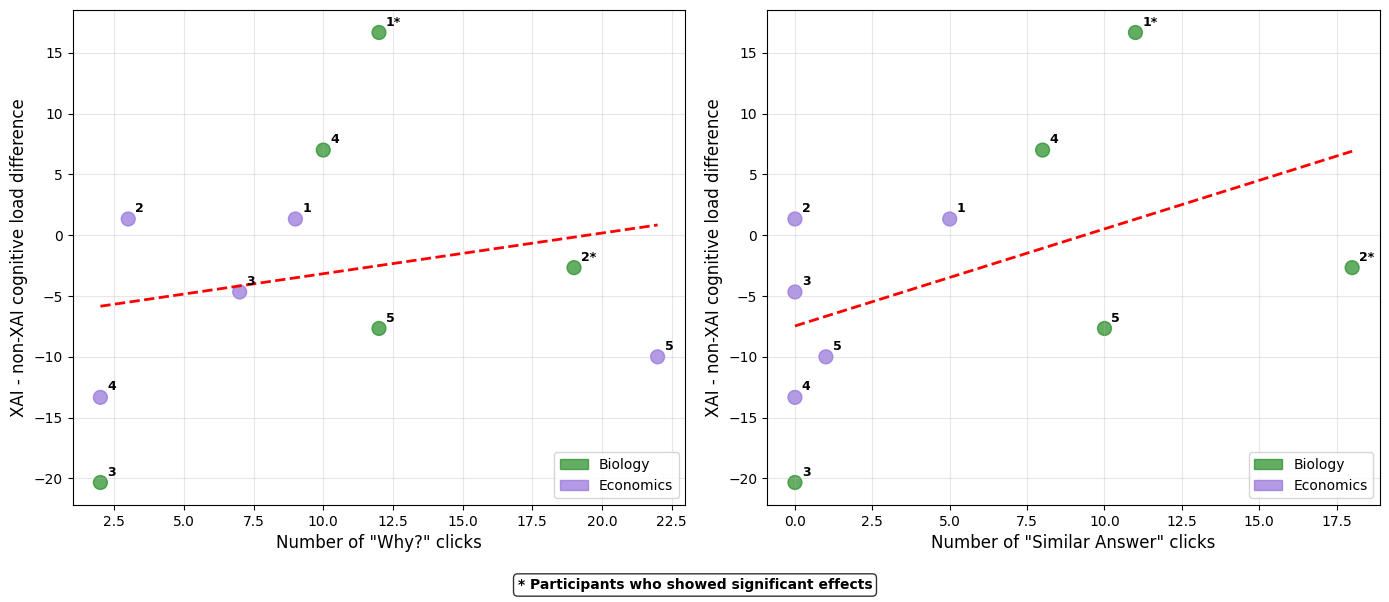

In [63]:
fig = plot_cognitive_load_vs_interactions(merged_data)
plt.show()